In [1]:
pip install toyplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.1/269.1 KB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 37.6 MB/s eta 0:00:00
  Created wheel for toyplot: filename=toyplot-1.0.3-py3-none-any.whl size=284047 sha256=ea55605b64e843e4c3efde4ee800ccc209b95525441f926e972ae03dc4823a01
  Stored in directory: /root/.cache/pip/wheels/c9/ef/2f/c58318e8bd173c8069cd80427bde338bb3cff5879bad21f124
Successfully built toyplot
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx 
from tqdm.auto import tqdm
import itertools
import re
import copy
import toyplot
#import seaborn as sns
from sklearn.cluster import KMeans
#from sklearn.decomposition import PCA
#from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
#from yellowbrick.cluster import KElbowVisualizer
from sklearn import preprocessing
#from sklearn.manifold import TSNE
#from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

In [3]:
ls drive/MyDrive/ВКР_Рекомендательная_система/

'!03&04_17_VSE.csv'            'выкупленные с классами.xlsx'
 витрина.xlsx                   города_для_регионов.xlsx
'витрина без нормировки.xlsx'   классы.xlsx
 выкупленные.xlsx               расставленные.xlsx


In [4]:
df_buy = pd.read_excel('drive/MyDrive/ВКР_Рекомендательная_система/выкупленные.xlsx',index_col=0)

In [5]:
df_class = pd.read_excel('drive/MyDrive/ВКР_Рекомендательная_система/классы.xlsx',index_col=0)

In [28]:
dict_class = dict(zip(df_class.Телефон_new,df_class.Class))

In [29]:
df_buy['Class'] = df_buy.apply(lambda x: dict_class[x['Телефон_new']], axis = 1)

In [ ]:
# df_finall_mart = pd.read_excel('drive/MyDrive/ВКР_Рекомендательная_система/витрина.xlsx',index_col=0)
# df_finall_mart_copy = df_finall_mart.copy()
# df_finall_mart_copy.drop(['КоличествоТоваров','Выручка','ПроцентОтмен',
#        'КоличествоЧековВсе', 'СреднийЧекВсе', 'СреднееЧислоТоваровЧекаВсе',
#        'ВыручкаВся', 'СредняяМаржаВся', 'ТОВАРЫ ДЛЯ ЖИВОТНЫХ', 'ТЕКСТИЛЬ, ТРИКОТАЖ','КРУПНОГАБАРИТНЫЙ ТОВАР','ИГРУШКИ_y','Регионы'], axis=1, inplace=True)

In [ ]:
# scaler = preprocessing.MinMaxScaler()
# d = scaler.fit_transform(df_finall_mart_copy)
# scaled_df1 = pd.DataFrame(d, columns=df_finall_mart_copy.columns)

# n_clusters = 8
# X=np.array(scaled_df1)
# kmeans = KMeans(n_clusters)
# kmeans.fit(X)
# cluster_labels = kmeans.predict(X)

# df_finall_mart_copy['Class'] = cluster_labels # записали классы в витрину

### def

In [68]:
def summary_about_group(x):
    result = {
        'Выручка': x['СуммаСтроки'].sum(),
        'Абсолютная Маржа': x['Маржа'].sum(),
        'Маржа (процентное соотношение)': x['Маржа'].sum() / x['СуммаСтроки'].sum(),
        'Количество чеков': x['НомерЗаказаНаСайте'].nunique(),
        'Количество товаров': x['КоличествоПроданоКлиенту'].sum(),
        'Количество клиентов': x['Телефон_new'].nunique(),        
        'Средний чек': x['СуммаСтроки'].sum() / x['НомерЗаказаНаСайте'].nunique(),
        'Среднее количество товаров в чеке': x['КоличествоПроданоКлиенту'].sum() / x['НомерЗаказаНаСайте'].nunique(),
        'Ценность клиента': x['Маржа'].sum() / x['Телефон_new'].nunique()
    }
    return pd.Series(result)

In [83]:
def df_for_graph(df, column_for_sort, num_top):
    df_top = df.copy()
    df_top.sort_values(by='confidence', axis=0, ascending=False, inplace=True)
    df_top['new'] = df_top.apply(lambda x: '_'.join(np.sort([x['antecedents'], x['consequents']])), axis=1)
    df_top.reset_index(drop=True, inplace=True)
    df_top.drop_duplicates(subset=['new'], keep='first', inplace=True)
    df_top.drop(['new'], axis=1, inplace=True)
    df_top = df_top[df_top['support']>0]
    df_top.sort_values(by=column_for_sort, axis=0, ascending=False, inplace=True)
    df_top.reset_index(drop=True, inplace=True)
    return df_top.head(num_top)

### Analysis by group

#### Товарные предпочтения

In [35]:
df_type = pd.crosstab(df_buy['Class'],
            df_buy['Тип'],
            values=df_buy['КоличествоПроданоКлиенту'],
            aggfunc='sum')

In [39]:
df_type

Тип,ИГРУШКИ,ИНОЕ,КГТ,ОДЕЖДА,ППКП
Class,,,,,
0,6990,1392,1904,16479,40514
1,6390,7065,1591,4341,105948
2,25432,205,667,1343,2028
3,224,19,12212,220,203
4,2115,273,916,18229,2117
5,27965,168,631,1897,1808


In [66]:
df_type_max = pd.DataFrame(df_type.idxmax(axis=1), columns=['Приоритетный товарный Тип'])
df_type_max

,Приоритетный товарный Тип
Class,
0,ППКП
1,ППКП
2,ИГРУШКИ
3,КГТ
4,ОДЕЖДА
5,ИГРУШКИ


In [48]:
df_group2 = pd.crosstab(df_buy['Class'],
            df_buy['Группа2'],
            values=df_buy['КоличествоПроданоКлиенту'],
            aggfunc='sum')
df_group2

Группа2,ДЕТСКОЕ ПИТАНИЕ,ЖЕНСКИЕ ШТУЧКИ,ИГРУШКИ,"КАНЦТОВАРЫ, КНИГИ, ДИСКИ",КОСМЕТИКА/ГИГИЕНА,КРУПНОГАБАРИТНЫЙ ТОВАР,ОБУВЬ,ПОДГУЗНИКИ,СОПУТСТВУЮЩИЕ ТОВАРЫ,"ТЕКСТИЛЬ, ТРИКОТАЖ",ТЕХНИКА И ТОВАРЫ ДЛЯ ДОМА,ТОВАРЫ ДЛЯ ЖИВОТНЫХ,ТОВАРЫ ДЛЯ КОРМЛЕНИЯ
Class,,,,,,,,,,,,,
0,8544.0,134.0,5470.0,1520.0,6084.0,1904.0,2050.0,18242.0,135.0,14429.0,7.0,1251.0,7509.0
1,68268.0,164.0,4860.0,1530.0,15558.0,1591.0,573.0,15294.0,109.0,3768.0,5.0,6896.0,6719.0
2,380.0,12.0,20019.0,5413.0,608.0,667.0,341.0,531.0,106.0,1002.0,2.0,191.0,403.0
3,2.0,2.0,192.0,32.0,36.0,12212.0,32.0,73.0,2.0,188.0,NaN,17.0,90.0
4,293.0,34.0,1712.0,403.0,689.0,916.0,2870.0,561.0,40.0,15359.0,3.0,236.0,534.0
5,71.0,40.0,22824.0,5141.0,298.0,631.0,323.0,748.0,132.0,1574.0,6.0,122.0,559.0


In [65]:
df_group2_max = pd.DataFrame(df_group2.idxmax(axis=1), columns=['Приоритетная товарная категория в Группа2'])
df_group2_max

,Приоритетная товарная категория в Группа2
Class,
0,ПОДГУЗНИКИ
1,ДЕТСКОЕ ПИТАНИЕ
2,ИГРУШКИ
3,КРУПНОГАБАРИТНЫЙ ТОВАР
4,"ТЕКСТИЛЬ, ТРИКОТАЖ"
5,ИГРУШКИ


In [73]:
df_group3 = pd.crosstab(df_buy['Class'],
            df_buy['Группа3'],
            values=df_buy['КоличествоПроданоКлиенту'],
            aggfunc='sum')
df_group3

Группа3,АВТОКРЕСЛА,АКСЕССУАРЫ,АКСЕССУАРЫ ДЛЯ ВОЛОС,АКСЕССУАРЫ ДЛЯ ДЕВОЧЕК,"АКСЕССУАРЫ МАКИЯЖ, МАНИКЮР",АКТИВНЫЙ ОТДЫХ,БАКАЛЕЯ,БИЖУТЕРИЯ,БУТЫЛОЧКИ,БЫТОВАЯ ХИМИЯ ДЛЯ ЖИВОТНЫХ,...,ТРУСИКИ НЕПРОМОКАЕМЫЕ,"ФИГУРЫ, ПЕРСОНАЖИ",ФОТОАЛЬБОМЫ/ФОТОРАМКИ,ХОДУНКИ/ПРЫГУНКИ,ХОЗЯЙСТВЕННЫЕ ТОВАРЫ,ЧАСЫ/ОЧКИ,"ШАПКИ, ШАРФЫ",ЭЛЕКТРОМОБИЛИ/МАШИНЫ ПЕДАЛЬНЫЕ,ЭЛЕКТРОПРИБОРЫ,ЭЛЕМЕНТЫ ПИТАНИЯ
Class,,,,,,,,,,,,,,,,,,,,,
0,151.0,2754.0,29.0,67.0,7.0,471.0,440.0,1.0,1043.0,2.0,...,636.0,135.0,28.0,37.0,10.0,NaN,2.0,8.0,197.0,37.0
1,94.0,2502.0,29.0,37.0,4.0,548.0,1014.0,NaN,886.0,26.0,...,264.0,118.0,21.0,54.0,22.0,2.0,NaN,1.0,161.0,43.0
2,41.0,163.0,3.0,52.0,NaN,1811.0,34.0,NaN,39.0,1.0,...,18.0,854.0,46.0,10.0,1.0,2.0,NaN,4.0,12.0,36.0
3,1355.0,37.0,NaN,1.0,NaN,27.0,2.0,NaN,8.0,NaN,...,1.0,4.0,NaN,120.0,NaN,NaN,NaN,212.0,14.0,1.0
4,64.0,237.0,17.0,26.0,1.0,107.0,22.0,NaN,85.0,NaN,...,16.0,51.0,4.0,11.0,3.0,2.0,NaN,3.0,14.0,5.0
5,45.0,203.0,10.0,50.0,1.0,1588.0,9.0,1.0,47.0,NaN,...,14.0,1065.0,56.0,22.0,8.0,1.0,1.0,10.0,11.0,54.0


In [77]:
df_group3_max = pd.DataFrame(df_group3.idxmax(axis=1), columns=['Приоритетная товарная категория в Группа3'])
df_group3_max

,Приоритетная товарная категория в Группа3
Class,
0,ПОДГУЗНИКИ
1,ПЮРЕ
2,ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ
3,КОЛЯСКИ
4,ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет)
5,ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ


In [79]:
df1 = pd.merge(df_type_max, df_group2_max, on='Class')
df2 = pd.merge(df1, df_group3_max, on='Class')
df3 = pd.merge(df2, df_buy.groupby(['Class']).apply(summary_about_group), on='Class')
df3

,Приоритетный товарный Тип,Приоритетная товарная категория в Группа2,Приоритетная товарная категория в Группа3,Выручка,Абсолютная Маржа,Маржа (процентное соотношение),Количество чеков,Количество товаров,Количество клиентов,Средний чек,Среднее количество товаров в чеке,Ценность клиента
Class,,,,,,,,,,,,
0,ППКП,ПОДГУЗНИКИ,ПОДГУЗНИКИ,49749548.85,8263411.98,0.166100,19815.0,67279.0,14351.0,2510.701431,3.395357,575.807399
1,ППКП,ДЕТСКОЕ ПИТАНИЕ,ПЮРЕ,40611826.00,4952097.96,0.121937,16191.0,125335.0,10433.0,2508.296337,7.741029,474.657142
2,ИГРУШКИ,ИГРУШКИ,ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ,17235388.18,3620173.28,0.210043,9410.0,29675.0,7963.0,1831.603420,3.153560,454.624297
3,КГТ,КРУПНОГАБАРИТНЫЙ ТОВАР,КОЛЯСКИ,83028755.70,25137077.37,0.302751,10956.0,12878.0,10197.0,7578.382229,1.175429,2465.144392
4,ОДЕЖДА,"ТЕКСТИЛЬ, ТРИКОТАЖ",ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет),19406585.43,5743062.24,0.295934,8054.0,23650.0,5841.0,2409.558658,2.936429,983.232707
5,ИГРУШКИ,ИГРУШКИ,ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ,21658207.40,4768149.45,0.220154,10729.0,32469.0,8964.0,2018.660397,3.026284,531.922072


### 0 сегмент

In [244]:
df_buy_segment0 = df_buy[df_buy['Class']==0] # вытащили 0 сегмент

In [245]:
print('Уникальных клиентов',df_buy_segment0['Телефон_new'].nunique())

Уникальных клиентов 14351


In [246]:
df_buy_segment0_onehot = pd.crosstab(df_buy_segment0.НомерЗаказаНаСайте, 
                                     df_buy_segment0.Группа3,
                                     values=df_buy_segment0['КоличествоПроданоКлиенту'],
                                     aggfunc='sum').fillna(0) # разбивка для ассоциативных правил по 0 сегменту
df_buy_segment0_onehot

Группа3,АВТОКРЕСЛА,АКСЕССУАРЫ,АКСЕССУАРЫ ДЛЯ ВОЛОС,АКСЕССУАРЫ ДЛЯ ДЕВОЧЕК,"АКСЕССУАРЫ МАКИЯЖ, МАНИКЮР",АКТИВНЫЙ ОТДЫХ,БАКАЛЕЯ,БИЖУТЕРИЯ,БУТЫЛОЧКИ,БЫТОВАЯ ХИМИЯ ДЛЯ ЖИВОТНЫХ,...,ТОВАРЫ ДЛЯ ЧЕРЕПАХ И РЕПТИЛИЙ,ТРУСИКИ НЕПРОМОКАЕМЫЕ,"ФИГУРЫ, ПЕРСОНАЖИ",ФОТОАЛЬБОМЫ/ФОТОРАМКИ,ХОДУНКИ/ПРЫГУНКИ,ХОЗЯЙСТВЕННЫЕ ТОВАРЫ,"ШАПКИ, ШАРФЫ",ЭЛЕКТРОМОБИЛИ/МАШИНЫ ПЕДАЛЬНЫЕ,ЭЛЕКТРОПРИБОРЫ,ЭЛЕМЕНТЫ ПИТАНИЯ
НомерЗаказаНаСайте,,,,,,,,,,,,,,,,,,,,,
1303000313_TR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1303000335_TR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1303000336_TR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1305001079_TR,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1867002630_TR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4513406_TR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4513436_TR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4513454_TR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [247]:
df_ass0_first = pd.DataFrame(list(itertools.combinations(df_buy_segment0.Группа3.unique(), 2)), columns=['antecedents', 'consequents']) # подсчет парных метрик
df_ass0_second = pd.DataFrame({'antecedents': list(df_ass0_first.consequents), 'consequents': list(df_ass0_first.antecedents)})
df_ass0 = pd.concat([df_ass0_first, df_ass0_second], ignore_index=True)

df_ass0['antecedents_support'] = df_ass0.apply(lambda x: len(df_buy_segment0_onehot[df_buy_segment0_onehot[x['antecedents']]>=1]) /len(df_buy_segment0_onehot), axis = 1)
df_ass0['consequents_support'] = df_ass0.apply(lambda x: len(df_buy_segment0_onehot[df_buy_segment0_onehot[x['consequents']]>=1]) /len(df_buy_segment0_onehot), axis = 1)
df_ass0['support'] = df_ass0.apply(lambda x: len(df_buy_segment0_onehot[(df_buy_segment0_onehot[x['antecedents']]>=1) & (df_buy_segment0_onehot[x['consequents']]>=1)]) /len(df_buy_segment0_onehot), axis = 1)
df_ass0['confidence'] = df_ass0.apply(lambda x: x['support']/x['antecedents_support'], axis = 1)
df_ass0['lift'] = df_ass0.apply(lambda x: x['support']/(x['antecedents_support']*x['consequents_support']), axis = 1)

In [248]:
df_ass0

,antecedents,consequents,antecedents_support,consequents_support,support,confidence,lift
0,ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет),ПОСТЕЛЬНОЕ БЕЛЬЕ,0.100984,0.042846,0.007721,0.076462,1.784558
1,ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет),АКСЕССУАРЫ ДЛЯ ДЕВОЧЕК,0.100984,0.002019,0.000606,0.005997,2.970765
2,ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет),ОБУВЬ ДЕТСКАЯ,0.100984,0.066818,0.003280,0.032484,0.486152
3,ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет),ДЕТСКАЯ ОДЕЖДА (7-16 лет),0.100984,0.021247,0.003583,0.035482,1.670026
4,ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет),ВЕРХНЯЯ ДЕТСКАЯ ОДЕЖДА,0.100984,0.070855,0.003886,0.038481,0.543088
...,...,...,...,...,...,...,...
6637,ТЕХНИКА ДЛЯ КРАСОТЫ И ЗДОРОВЬЯ,ГАЛАНТЕРЕЯ,0.000101,0.000101,0.000000,0.000000,0.000000
6638,ТОВАРЫ ДЛЯ ЧЕРЕПАХ И РЕПТИЛИЙ,ГАЛАНТЕРЕЯ,0.000101,0.000101,0.000000,0.000000,0.000000
6639,ТЕХНИКА ДЛЯ КРАСОТЫ И ЗДОРОВЬЯ,БЫТОВАЯ ХИМИЯ ДЛЯ ЖИВОТНЫХ,0.000101,0.000101,0.000000,0.000000,0.000000
6640,ТОВАРЫ ДЛЯ ЧЕРЕПАХ И РЕПТИЛИЙ,БЫТОВАЯ ХИМИЯ ДЛЯ ЖИВОТНЫХ,0.000101,0.000101,0.000000,0.000000,0.000000


In [144]:
# df_priority = df_ass0.loc[[df_ass0[['support', 'confidence', 'lift']].sum(axis=1).idxmax()]]
# df_priority

,antecedents,consequents,antecedents_support,consequents_support,support,confidence,lift
1678,"АКСЕССУАРЫ МАКИЯЖ, МАНИКЮР",ХОЗЯЙСТВЕННЫЕ ТОВАРЫ,0.000202,0.000353,0.000101,0.5,1415.357143


In [ ]:
#df_ass0.to_excel("ассоциативные правила для 0 класса.xlsx") 

In [116]:
num_top = 20
feature = 'confidence'
df_graph_top30_confidence = df_for_graph(df_ass0, feature, num_top)
G_confidence=nx.from_pandas_edgelist(df_graph_top30_confidence, 'antecedents', 'consequents', create_using=nx.DiGraph())

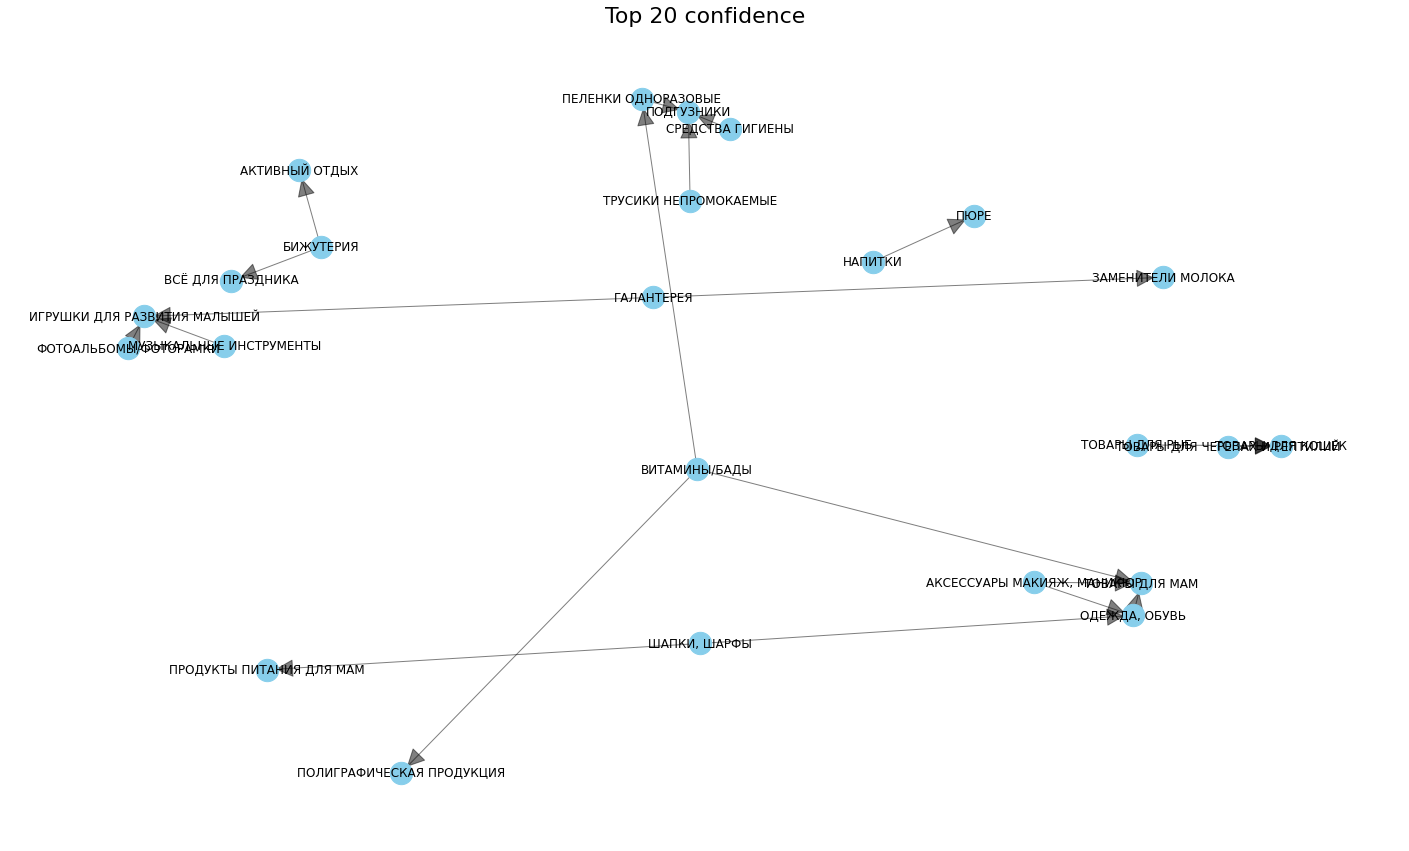

In [117]:
fig = plt.figure(figsize=(25,15))
pos=nx.spring_layout(G_confidence)
nx.draw_networkx_nodes(G_confidence, pos, node_color='skyblue',node_size=500)
nx.draw_networkx_edges(G_confidence, pos, alpha=0.5, arrowsize=40)
nx.draw_networkx_labels(G_confidence,pos)
plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
plt.axis("off")
plt.show()

In [249]:
num_top = 20
feature = 'support'
df_graph_top30_support = df_for_graph(df_ass0, feature, num_top)
G_support=nx.from_pandas_edgelist(df_graph_top30_support, 'antecedents', 'consequents', create_using=nx.DiGraph())

In [254]:
df_ = df_graph_top30_support[df_graph_top30_support['support'] == df_graph_top30_support['support'].max()]
df_

,antecedents,consequents,antecedents_support,consequents_support,support,confidence,lift
0,СРЕДСТВА ГИГИЕНЫ,ПОДГУЗНИКИ,0.058239,0.441938,0.037951,0.651646,1.47452


In [255]:
df_priority = df_

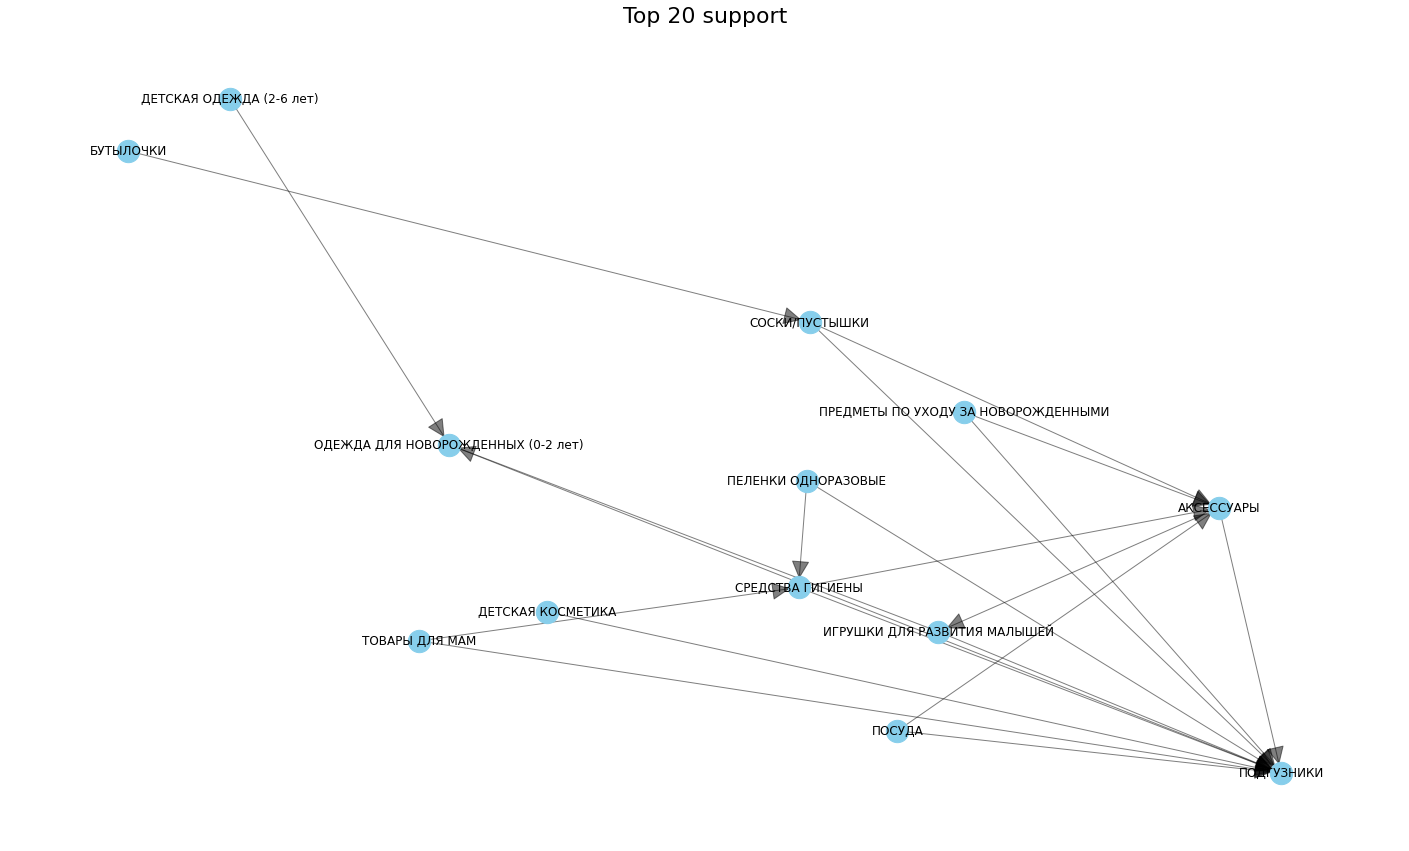

In [120]:
pos=nx.spring_layout(G_support)
fig = plt.figure(figsize=(25,15))
nx.draw_networkx_nodes(G_support,pos, node_color='skyblue',node_size=500)
nx.draw_networkx_edges(G_support, pos, alpha=0.5, arrowsize=40)
nx.draw_networkx_labels(G_support,pos)
plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
plt.axis("off")
plt.show()

In [121]:
num_top = 20
feature = 'lift'
df_graph_top30_lift = df_for_graph(df_ass0, feature, num_top)
G_lift=nx.from_pandas_edgelist(df_graph_top30_lift, 'antecedents', 'consequents', create_using=nx.DiGraph())

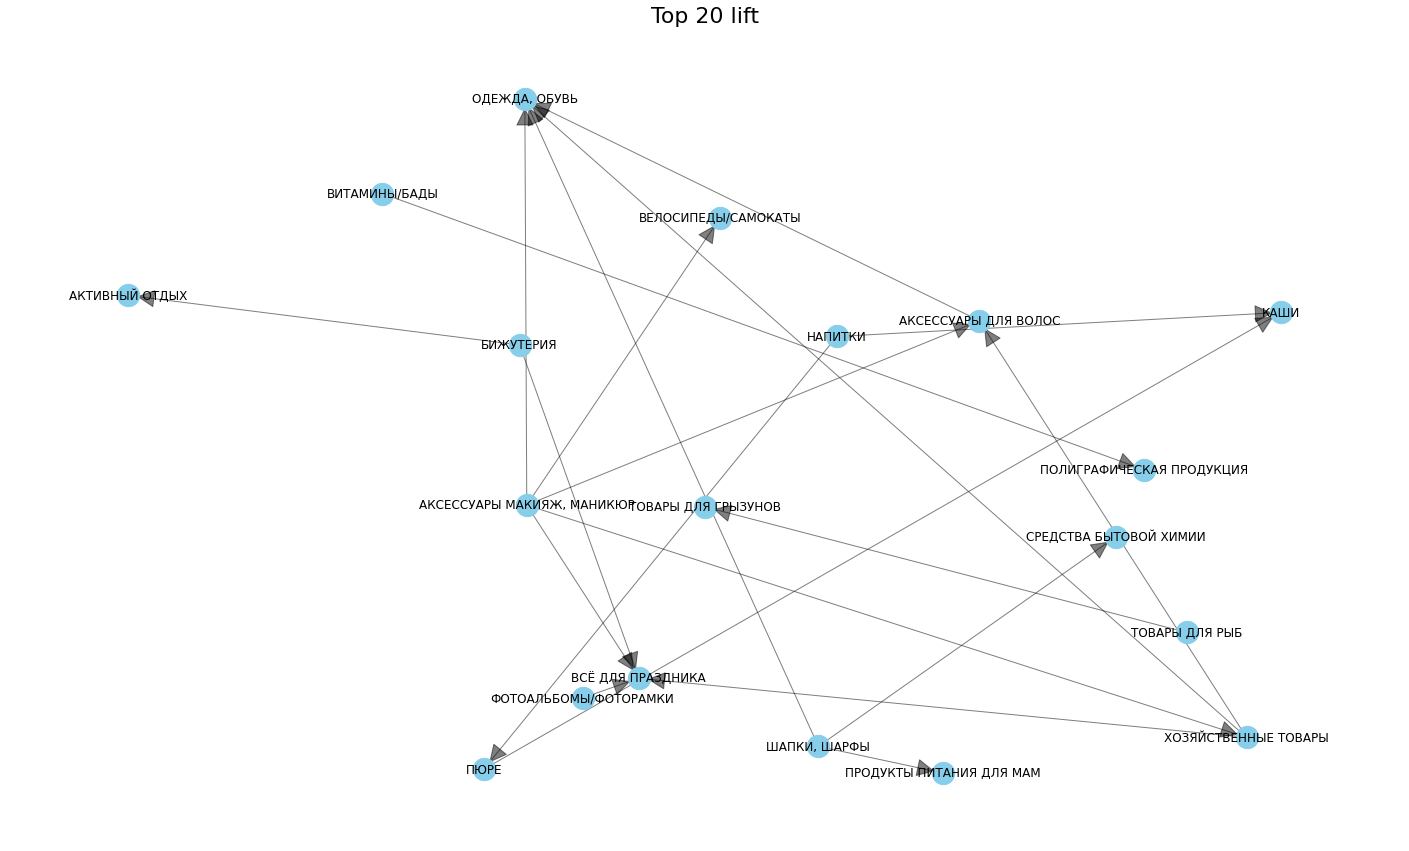

In [126]:
G = G_lift
pos=nx.random_layout(G)
fig = plt.figure(figsize=(25,15))
nx.draw_networkx_nodes(G,pos, node_color='skyblue',node_size=500)
nx.draw_networkx_edges(G, pos, alpha=0.5, arrowsize=40)
nx.draw_networkx_labels(G,pos)
plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
plt.axis("off")
plt.show()

### 1 сегмент

In [256]:
df_buy_segment0 = df_buy[df_buy['Class']==1] # вытащили 1 сегмент

In [257]:
print('Уникальных клиентов',df_buy_segment0['Телефон_new'].nunique())

Уникальных клиентов 10433


In [258]:
df_buy_segment0_onehot = pd.crosstab(df_buy_segment0.НомерЗаказаНаСайте, 
                                     df_buy_segment0.Группа3,
                                     values=df_buy_segment0['КоличествоПроданоКлиенту'],
                                     aggfunc='sum').fillna(0) # разбивка для ассоциативных правил по сегменту

In [259]:
df_ass0_first = pd.DataFrame(list(itertools.combinations(df_buy_segment0.Группа3.unique(), 2)), columns=['antecedents', 'consequents']) # подсчет парных метрик
df_ass0_second = pd.DataFrame({'antecedents': list(df_ass0_first.consequents), 'consequents': list(df_ass0_first.antecedents)})
df_ass0 = pd.concat([df_ass0_first, df_ass0_second], ignore_index=True)

df_ass0['antecedents_support'] = df_ass0.apply(lambda x: len(df_buy_segment0_onehot[df_buy_segment0_onehot[x['antecedents']]>=1]) /len(df_buy_segment0_onehot), axis = 1)
df_ass0['consequents_support'] = df_ass0.apply(lambda x: len(df_buy_segment0_onehot[df_buy_segment0_onehot[x['consequents']]>=1]) /len(df_buy_segment0_onehot), axis = 1)
df_ass0['support'] = df_ass0.apply(lambda x: len(df_buy_segment0_onehot[(df_buy_segment0_onehot[x['antecedents']]>=1) & (df_buy_segment0_onehot[x['consequents']]>=1)]) /len(df_buy_segment0_onehot), axis = 1)
df_ass0['confidence'] = df_ass0.apply(lambda x: x['support']/x['antecedents_support'], axis = 1)
df_ass0['lift'] = df_ass0.apply(lambda x: x['support']/(x['antecedents_support']*x['consequents_support']), axis = 1)

In [260]:
df_ass0

,antecedents,consequents,antecedents_support,consequents_support,support,confidence,lift
0,ПОСТЕЛЬНОЕ БЕЛЬЕ,СПОРТИВНЫЕ КОМПЛЕКСЫ И ПЕСОЧНИЦЫ,0.020011,0.004817,0.000062,0.003086,0.640670
1,ПОСТЕЛЬНОЕ БЕЛЬЕ,ИГРУШКИ ДЛЯ ДЕВОЧЕК,0.020011,0.014700,0.000309,0.015432,1.049837
2,ПОСТЕЛЬНОЕ БЕЛЬЕ,ПОДГУЗНИКИ,0.020011,0.482120,0.006856,0.342593,0.710597
3,ПОСТЕЛЬНОЕ БЕЛЬЕ,ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет),0.020011,0.043296,0.003397,0.169753,3.920788
4,ПОСТЕЛЬНОЕ БЕЛЬЕ,КОЛЯСКИ,0.020011,0.014267,0.000618,0.030864,2.163300
...,...,...,...,...,...,...,...
6967,СУВЕНИРНАЯ ПРОДУКЦИЯ,СПОРТ.ИНВЕНТАРЬ,0.000062,0.000062,0.000000,0.000000,0.000000
6968,СИСТЕМЫ ХРАНЕНИЯ,СПОРТ.ИНВЕНТАРЬ,0.000062,0.000062,0.000000,0.000000,0.000000
6969,СУВЕНИРНАЯ ПРОДУКЦИЯ,ГАЛАНТЕРЕЯ,0.000062,0.000062,0.000000,0.000000,0.000000
6970,СИСТЕМЫ ХРАНЕНИЯ,ГАЛАНТЕРЕЯ,0.000062,0.000062,0.000000,0.000000,0.000000


In [153]:
num_top = 20
feature = 'confidence'
df_graph_top30_confidence = df_for_graph(df_ass0, feature, num_top)
G_confidence=nx.from_pandas_edgelist(df_graph_top30_confidence, 'antecedents', 'consequents', create_using=nx.DiGraph())

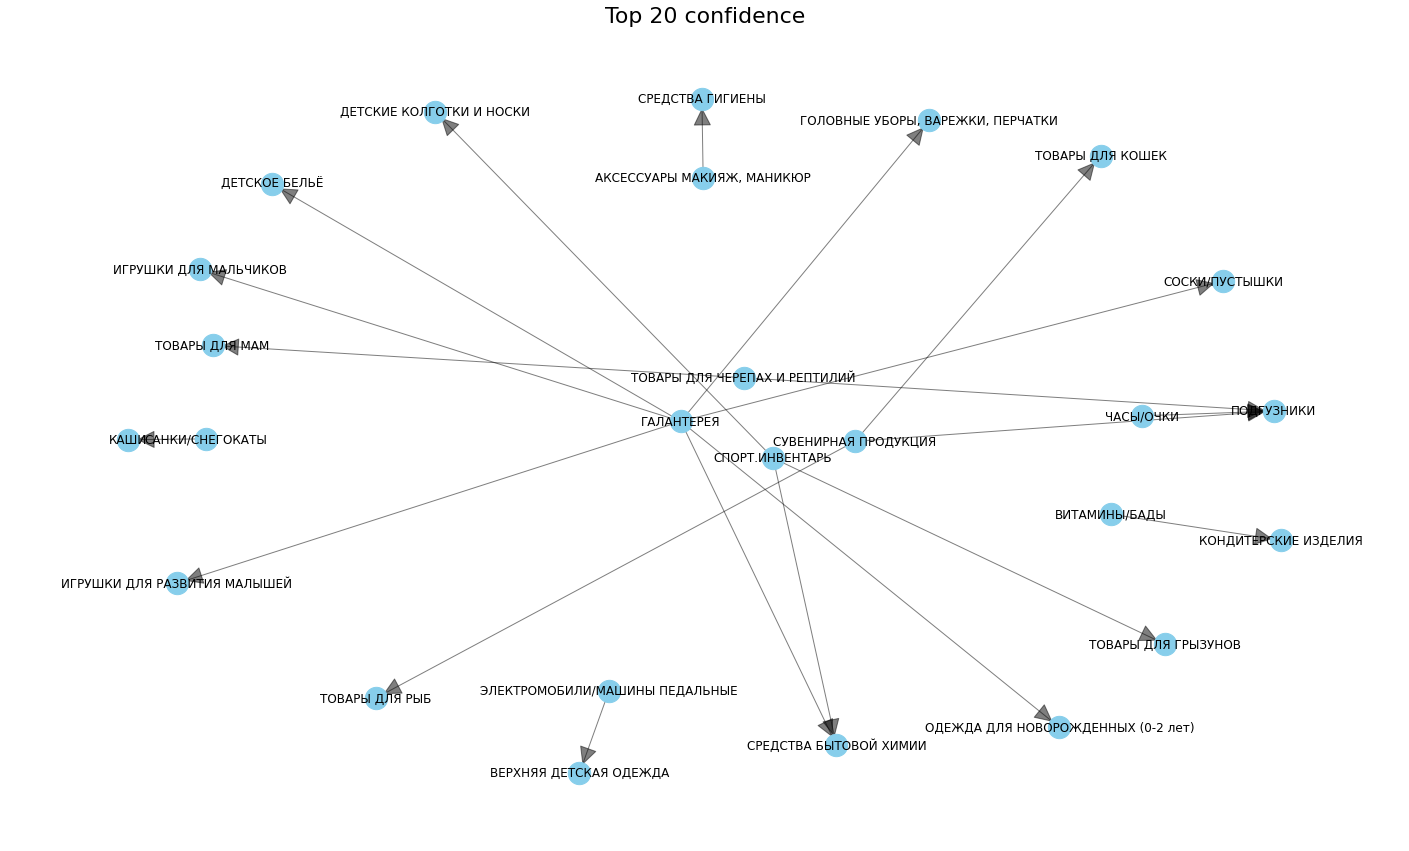

In [154]:
fig = plt.figure(figsize=(25,15))
pos=nx.spring_layout(G_confidence)
nx.draw_networkx_nodes(G_confidence, pos, node_color='skyblue',node_size=500)
nx.draw_networkx_edges(G_confidence, pos, alpha=0.5, arrowsize=40)
nx.draw_networkx_labels(G_confidence,pos)
plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
plt.axis("off")
plt.show()

In [261]:
num_top = 20
feature = 'support'
df_graph_top30_support = df_for_graph(df_ass0, feature, num_top)
G_support=nx.from_pandas_edgelist(df_graph_top30_support, 'antecedents', 'consequents', create_using=nx.DiGraph())

In [262]:
df_ = df_graph_top30_support[df_graph_top30_support['support'] == df_graph_top30_support['support'].max()]
df_

,antecedents,consequents,antecedents_support,consequents_support,support,confidence,lift
0,СРЕДСТВА ГИГИЕНЫ,ПОДГУЗНИКИ,0.112779,0.48212,0.070162,0.622125,1.290395


In [263]:
df_priority = pd.concat([df_priority, df_])

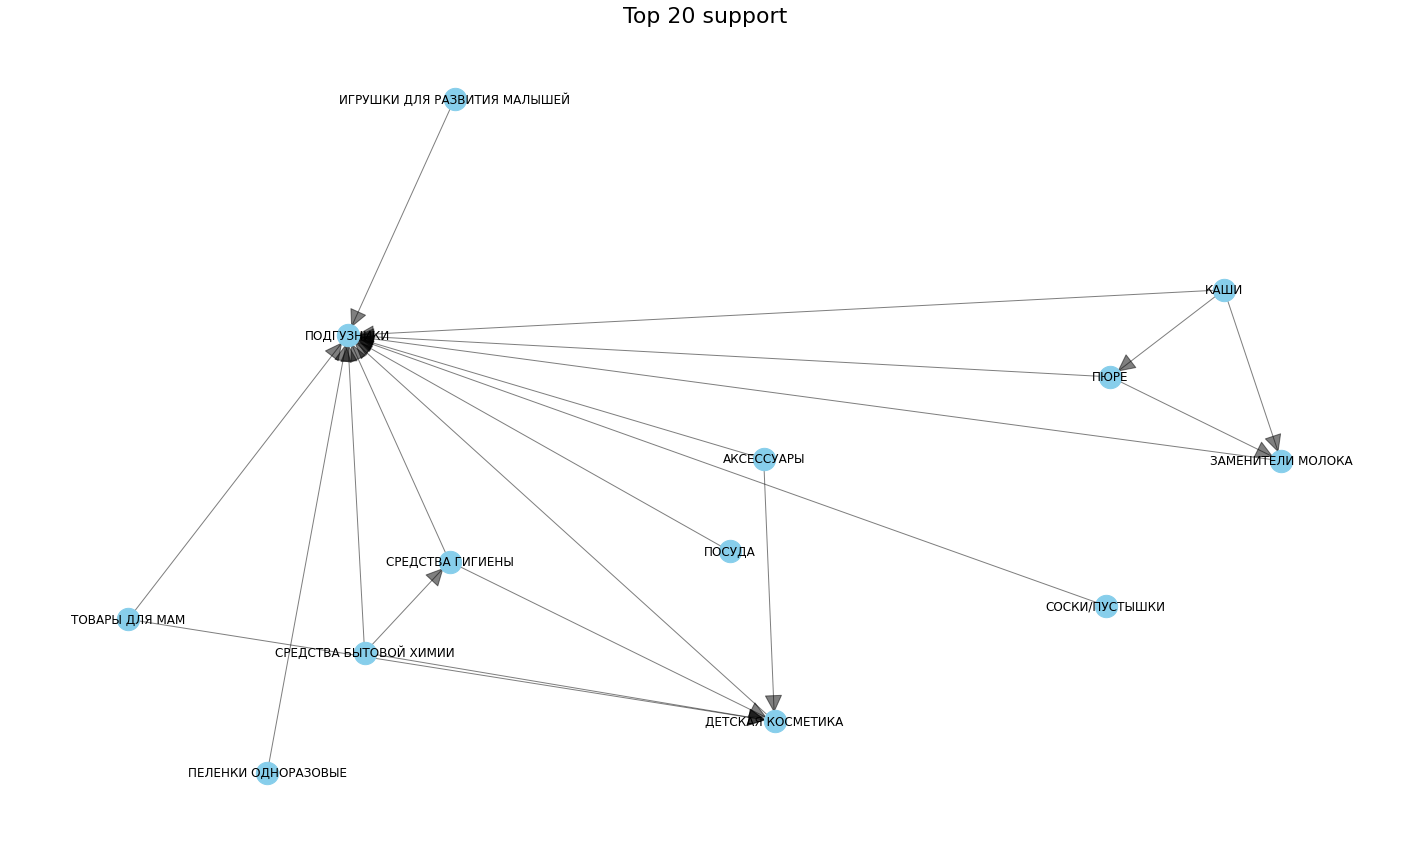

In [156]:
pos=nx.spring_layout(G_support)
fig = plt.figure(figsize=(25,15))
nx.draw_networkx_nodes(G_support,pos, node_color='skyblue',node_size=500)
nx.draw_networkx_edges(G_support, pos, alpha=0.5, arrowsize=40)
nx.draw_networkx_labels(G_support,pos)
plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
plt.axis("off")
plt.show()

In [157]:
num_top = 20
feature = 'lift'
df_graph_top30_lift = df_for_graph(df_ass0, feature, num_top)
G_lift=nx.from_pandas_edgelist(df_graph_top30_lift, 'antecedents', 'consequents', create_using=nx.DiGraph())

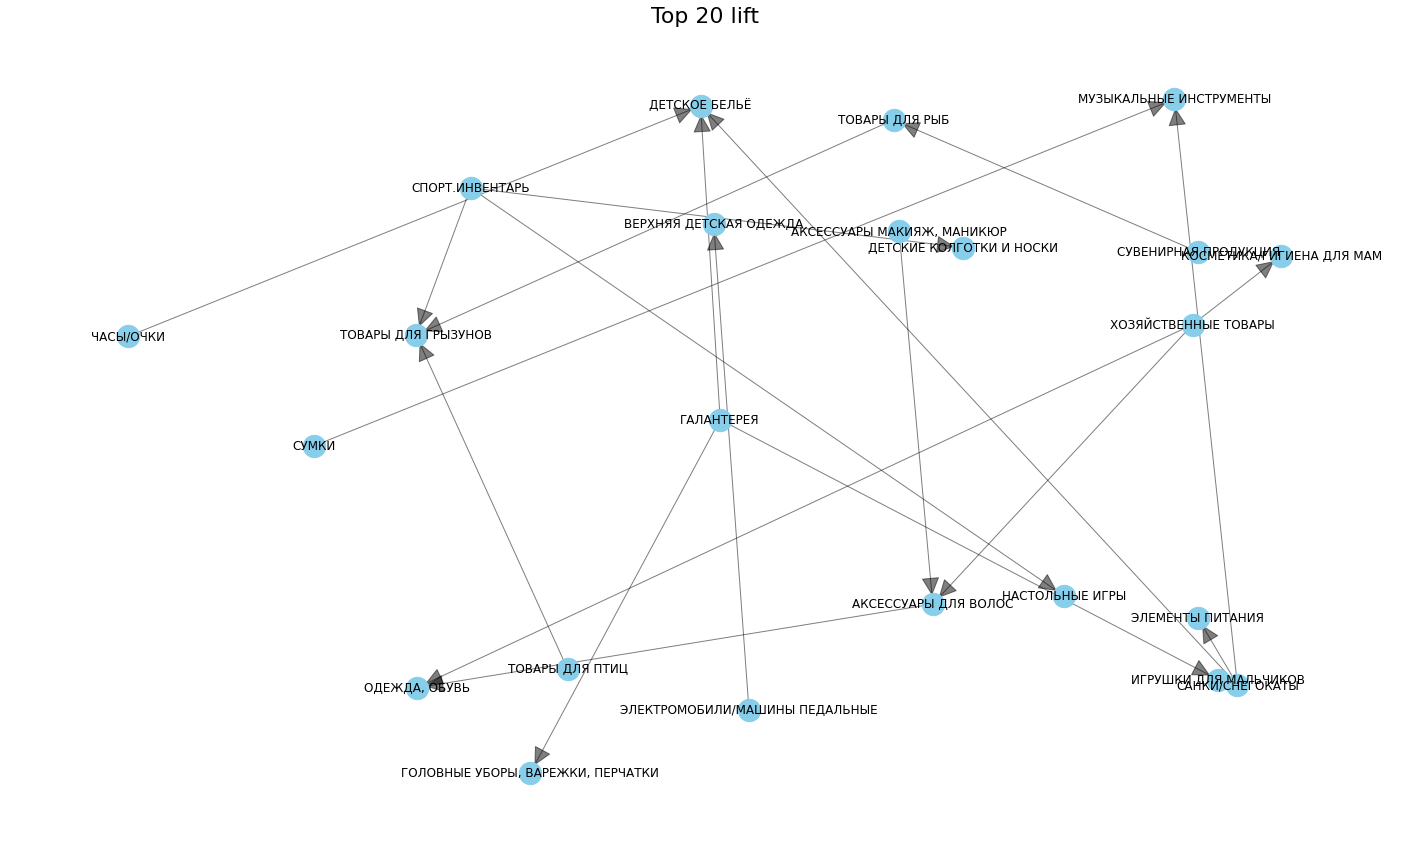

In [158]:
G = G_lift
pos=nx.random_layout(G)
fig = plt.figure(figsize=(25,15))
nx.draw_networkx_nodes(G,pos, node_color='skyblue',node_size=500)
nx.draw_networkx_edges(G, pos, alpha=0.5, arrowsize=40)
nx.draw_networkx_labels(G,pos)
plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
plt.axis("off")
plt.show()

### 2 сегмент

In [264]:
df_buy_segment0 = df_buy[df_buy['Class']==2] # вытащили 2 сегмент

In [265]:
print('Уникальных клиентов',df_buy_segment0['Телефон_new'].nunique())

Уникальных клиентов 7963


In [266]:
df_buy_segment0_onehot = pd.crosstab(df_buy_segment0.НомерЗаказаНаСайте, 
                                     df_buy_segment0.Группа3,
                                     values=df_buy_segment0['КоличествоПроданоКлиенту'],
                                     aggfunc='sum').fillna(0) # разбивка для ассоциативных правил по сегменту

In [267]:
df_ass0_first = pd.DataFrame(list(itertools.combinations(df_buy_segment0.Группа3.unique(), 2)), columns=['antecedents', 'consequents']) # подсчет парных метрик
df_ass0_second = pd.DataFrame({'antecedents': list(df_ass0_first.consequents), 'consequents': list(df_ass0_first.antecedents)})
df_ass0 = pd.concat([df_ass0_first, df_ass0_second], ignore_index=True)

df_ass0['antecedents_support'] = df_ass0.apply(lambda x: len(df_buy_segment0_onehot[df_buy_segment0_onehot[x['antecedents']]>=1]) /len(df_buy_segment0_onehot), axis = 1)
df_ass0['consequents_support'] = df_ass0.apply(lambda x: len(df_buy_segment0_onehot[df_buy_segment0_onehot[x['consequents']]>=1]) /len(df_buy_segment0_onehot), axis = 1)
df_ass0['support'] = df_ass0.apply(lambda x: len(df_buy_segment0_onehot[(df_buy_segment0_onehot[x['antecedents']]>=1) & (df_buy_segment0_onehot[x['consequents']]>=1)]) /len(df_buy_segment0_onehot), axis = 1)
df_ass0['confidence'] = df_ass0.apply(lambda x: x['support']/x['antecedents_support'], axis = 1)
df_ass0['lift'] = df_ass0.apply(lambda x: x['support']/(x['antecedents_support']*x['consequents_support']), axis = 1)

In [268]:
df_ass0

,antecedents,consequents,antecedents_support,consequents_support,support,confidence,lift
0,КОЛЯСКИ ДЛЯ КУКОЛ,МЯГКИЕ ИГРУШКИ,0.007333,0.029649,0.000000,0.000000,0.000000
1,КОЛЯСКИ ДЛЯ КУКОЛ,ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ,0.007333,0.256004,0.001807,0.246377,0.962393
2,КОЛЯСКИ ДЛЯ КУКОЛ,ИГРУШКИ ДЛЯ ДЕВОЧЕК,0.007333,0.171307,0.003294,0.449275,2.622631
3,КОЛЯСКИ ДЛЯ КУКОЛ,СПОРТИВНЫЕ КОМПЛЕКСЫ И ПЕСОЧНИЦЫ,0.007333,0.009777,0.000213,0.028986,2.964713
4,КОЛЯСКИ ДЛЯ КУКОЛ,ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет),0.007333,0.015303,0.000213,0.028986,1.894122
...,...,...,...,...,...,...,...
5695,ЛАМПЫ/СВЕТИЛЬНИКИ,ЧАСЫ/ОЧКИ,0.000213,0.000106,0.000000,0.000000,0.000000
5696,ТОВАРЫ ДЛЯ ПТИЦ,ЧАСЫ/ОЧКИ,0.000319,0.000106,0.000000,0.000000,0.000000
5697,ЛАМПЫ/СВЕТИЛЬНИКИ,"ОДЕЖДА, ОБУВЬ",0.000213,0.000319,0.000000,0.000000,0.000000
5698,ТОВАРЫ ДЛЯ ПТИЦ,"ОДЕЖДА, ОБУВЬ",0.000319,0.000319,0.000000,0.000000,0.000000


In [166]:
num_top = 20
feature = 'confidence'
df_graph_top30_confidence = df_for_graph(df_ass0, feature, num_top)
G_confidence=nx.from_pandas_edgelist(df_graph_top30_confidence, 'antecedents', 'consequents', create_using=nx.DiGraph())

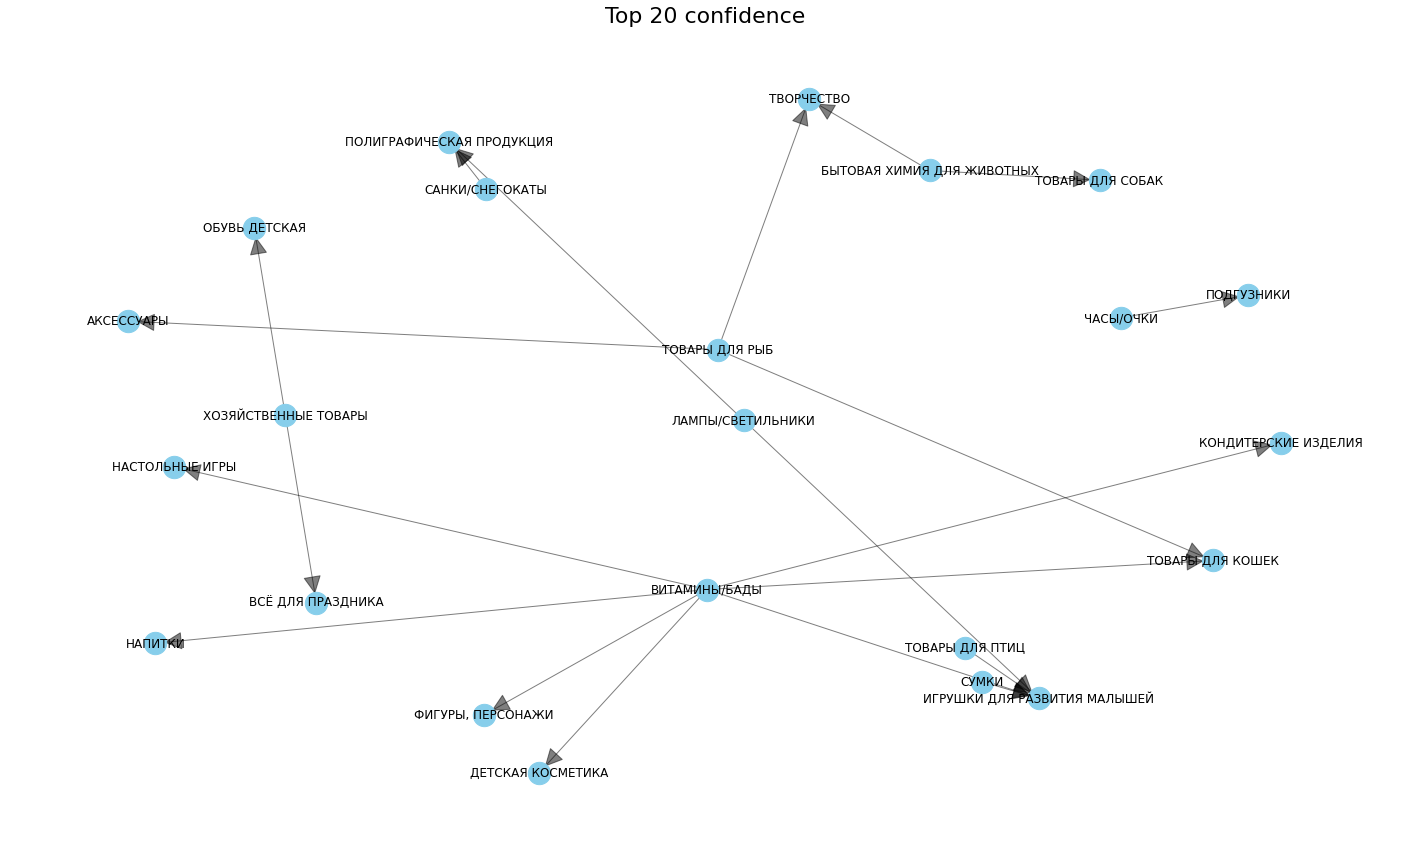

In [167]:
fig = plt.figure(figsize=(25,15))
pos=nx.spring_layout(G_confidence)
nx.draw_networkx_nodes(G_confidence, pos, node_color='skyblue',node_size=500)
nx.draw_networkx_edges(G_confidence, pos, alpha=0.5, arrowsize=40)
nx.draw_networkx_labels(G_confidence,pos)
plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
plt.axis("off")
plt.show()

In [269]:
num_top = 20
feature = 'support'
df_graph_top30_support = df_for_graph(df_ass0, feature, num_top)
G_support=nx.from_pandas_edgelist(df_graph_top30_support, 'antecedents', 'consequents', create_using=nx.DiGraph())

In [270]:
df_ = df_graph_top30_support[df_graph_top30_support['support'] == df_graph_top30_support['support'].max()]
df_

,antecedents,consequents,antecedents_support,consequents_support,support,confidence,lift
0,НАСТОЛЬНЫЕ ИГРЫ,ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ,0.124336,0.256004,0.030499,0.245299,0.958184


In [271]:
df_priority = pd.concat([df_priority, df_])

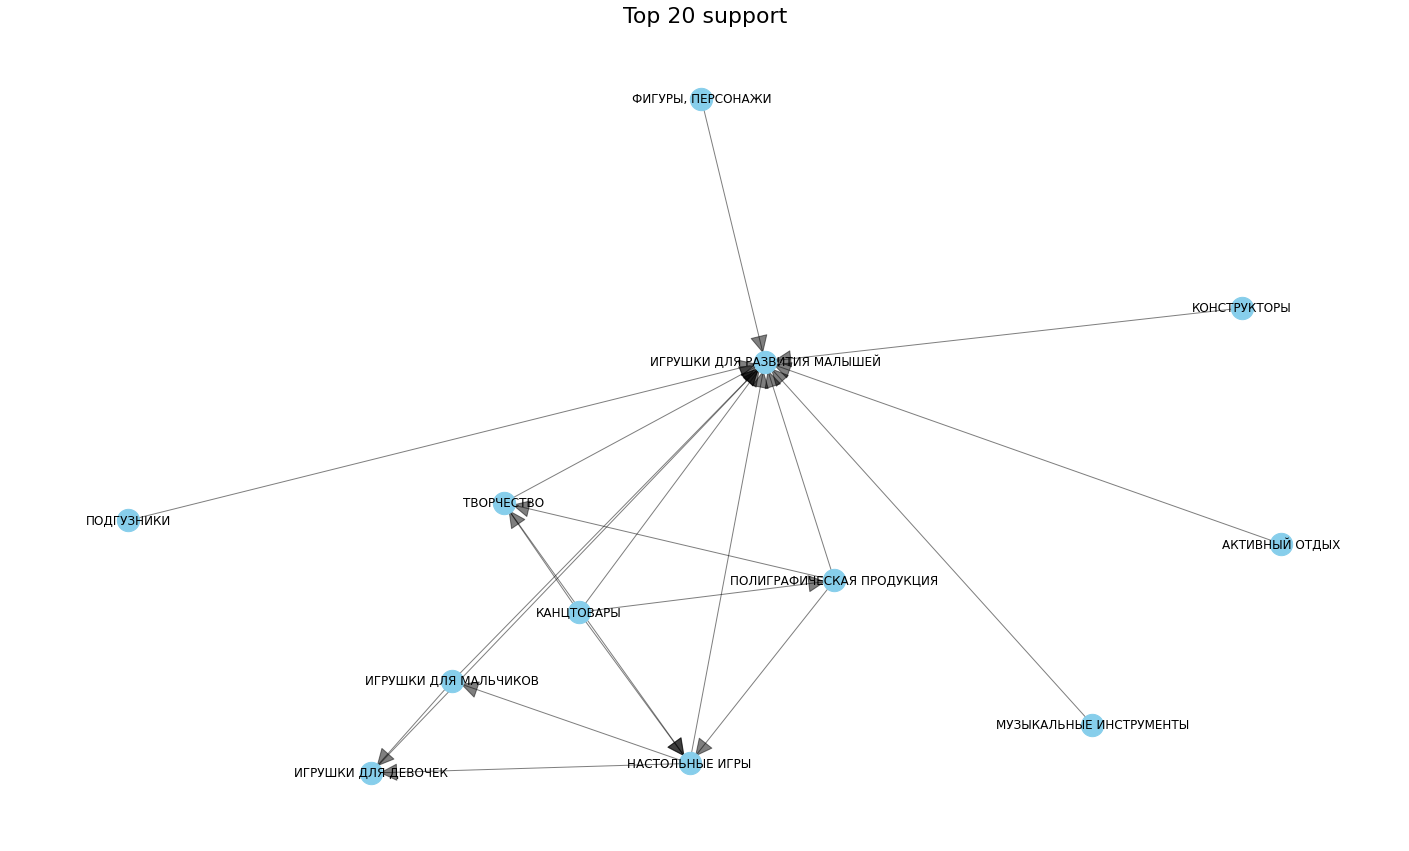

In [169]:
pos=nx.spring_layout(G_support)
fig = plt.figure(figsize=(25,15))
nx.draw_networkx_nodes(G_support,pos, node_color='skyblue',node_size=500)
nx.draw_networkx_edges(G_support, pos, alpha=0.5, arrowsize=40)
nx.draw_networkx_labels(G_support,pos)
plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
plt.axis("off")
plt.show()

In [170]:
num_top = 20
feature = 'lift'
df_graph_top30_lift = df_for_graph(df_ass0, feature, num_top)
G_lift=nx.from_pandas_edgelist(df_graph_top30_lift, 'antecedents', 'consequents', create_using=nx.DiGraph())

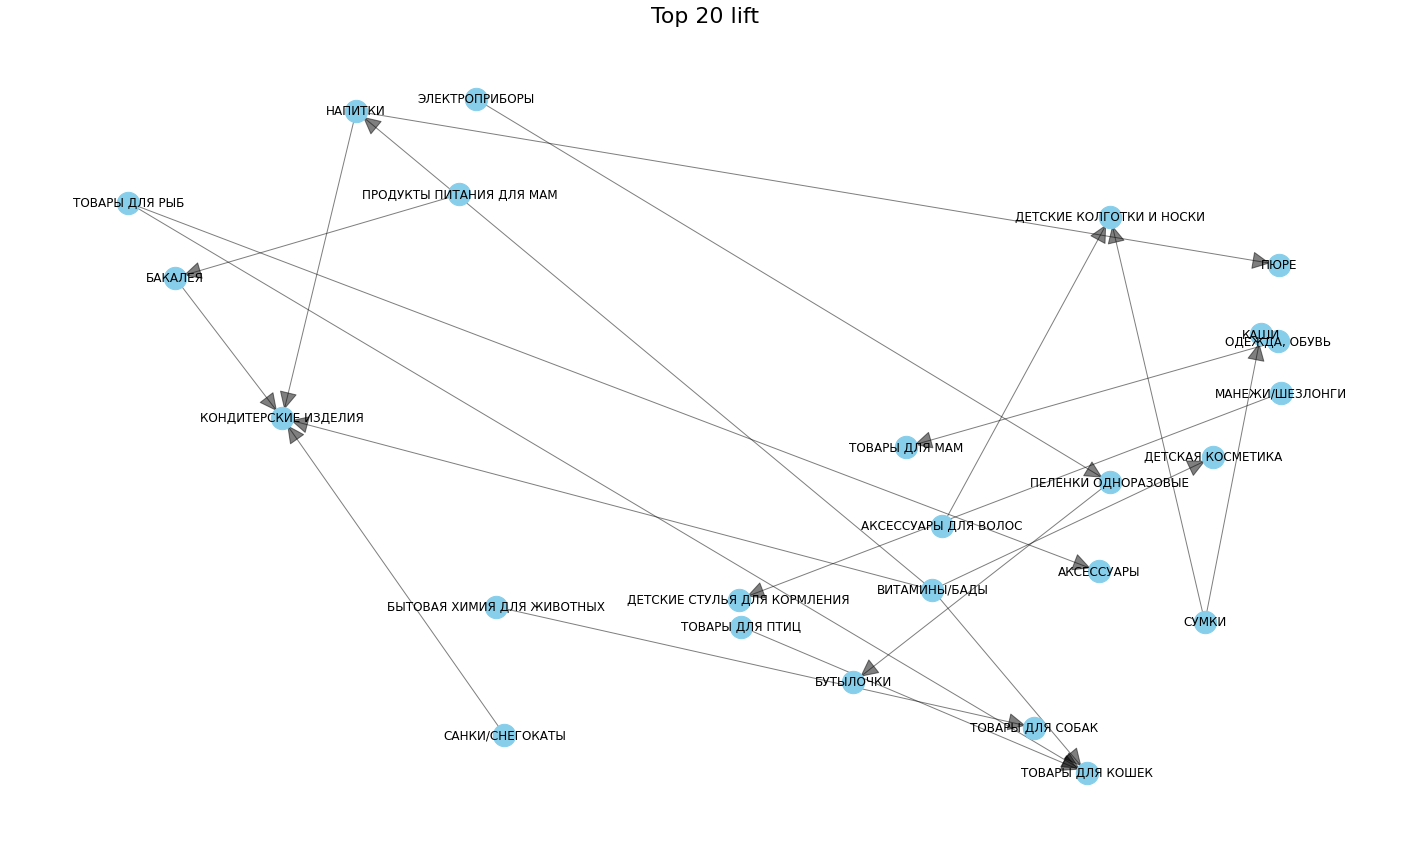

In [184]:
G = G_lift
pos=nx.random_layout(G)
fig = plt.figure(figsize=(25,15))
nx.draw_networkx_nodes(G,pos, node_color='skyblue',node_size=500)
nx.draw_networkx_edges(G, pos, alpha=0.5, arrowsize=40)
nx.draw_networkx_labels(G,pos)
plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
plt.axis("off")
plt.show()

### 3 сегмент

In [272]:
df_buy_segment0 = df_buy[df_buy['Class']==3] 

In [273]:
print('Уникальных клиентов',df_buy_segment0['Телефон_new'].nunique())

Уникальных клиентов 10197


In [274]:
df_buy_segment0_onehot = pd.crosstab(df_buy_segment0.НомерЗаказаНаСайте, 
                                     df_buy_segment0.Группа3,
                                     values=df_buy_segment0['КоличествоПроданоКлиенту'],
                                     aggfunc='sum').fillna(0) # разбивка для ассоциативных правил по сегменту

In [275]:
df_ass0_first = pd.DataFrame(list(itertools.combinations(df_buy_segment0.Группа3.unique(), 2)), columns=['antecedents', 'consequents']) # подсчет парных метрик
df_ass0_second = pd.DataFrame({'antecedents': list(df_ass0_first.consequents), 'consequents': list(df_ass0_first.antecedents)})
df_ass0 = pd.concat([df_ass0_first, df_ass0_second], ignore_index=True)

df_ass0['antecedents_support'] = df_ass0.apply(lambda x: len(df_buy_segment0_onehot[df_buy_segment0_onehot[x['antecedents']]>=1]) /len(df_buy_segment0_onehot), axis = 1)
df_ass0['consequents_support'] = df_ass0.apply(lambda x: len(df_buy_segment0_onehot[df_buy_segment0_onehot[x['consequents']]>=1]) /len(df_buy_segment0_onehot), axis = 1)
df_ass0['support'] = df_ass0.apply(lambda x: len(df_buy_segment0_onehot[(df_buy_segment0_onehot[x['antecedents']]>=1) & (df_buy_segment0_onehot[x['consequents']]>=1)]) /len(df_buy_segment0_onehot), axis = 1)
df_ass0['confidence'] = df_ass0.apply(lambda x: x['support']/x['antecedents_support'], axis = 1)
df_ass0['lift'] = df_ass0.apply(lambda x: x['support']/(x['antecedents_support']*x['consequents_support']), axis = 1)

In [276]:
df_ass0

,antecedents,consequents,antecedents_support,consequents_support,support,confidence,lift
0,КОЛЯСКИ,ДЕТСКИЕ СТУЛЬЯ ДЛЯ КОРМЛЕНИЯ,0.275009,0.070464,0.001369,0.004978,0.070652
1,КОЛЯСКИ,КАТАЛКИ/КАЧАЛКИ,0.275009,0.036510,0.000274,0.000996,0.027272
2,КОЛЯСКИ,АВТОКРЕСЛА,0.275009,0.117014,0.003651,0.013276,0.113455
3,КОЛЯСКИ,ИЗДЕЛИЯ ИЗ ПЛАСТМАССЫ,0.275009,0.032311,0.002191,0.007965,0.246525
4,КОЛЯСКИ,"ДЕТСКАЯ МЕБЕЛЬ, МАТРАСЫ",0.275009,0.179901,0.008306,0.030202,0.167883
...,...,...,...,...,...,...,...
3187,ТОВАРЫ ДЛЯ ПТИЦ,ТРУСИКИ НЕПРОМОКАЕМЫЕ,0.000091,0.000091,0.000000,0.000000,0.000000
3188,БАКАЛЕЯ,ТРУСИКИ НЕПРОМОКАЕМЫЕ,0.000091,0.000091,0.000000,0.000000,0.000000
3189,ТОВАРЫ ДЛЯ ПТИЦ,СРЕДСТВА БЫТОВОЙ ХИМИИ,0.000091,0.000183,0.000000,0.000000,0.000000
3190,БАКАЛЕЯ,СРЕДСТВА БЫТОВОЙ ХИМИИ,0.000091,0.000183,0.000000,0.000000,0.000000


In [192]:
num_top = 20
feature = 'confidence'
df_graph_top30_confidence = df_for_graph(df_ass0, feature, num_top)
G_confidence=nx.from_pandas_edgelist(df_graph_top30_confidence, 'antecedents', 'consequents', create_using=nx.DiGraph())

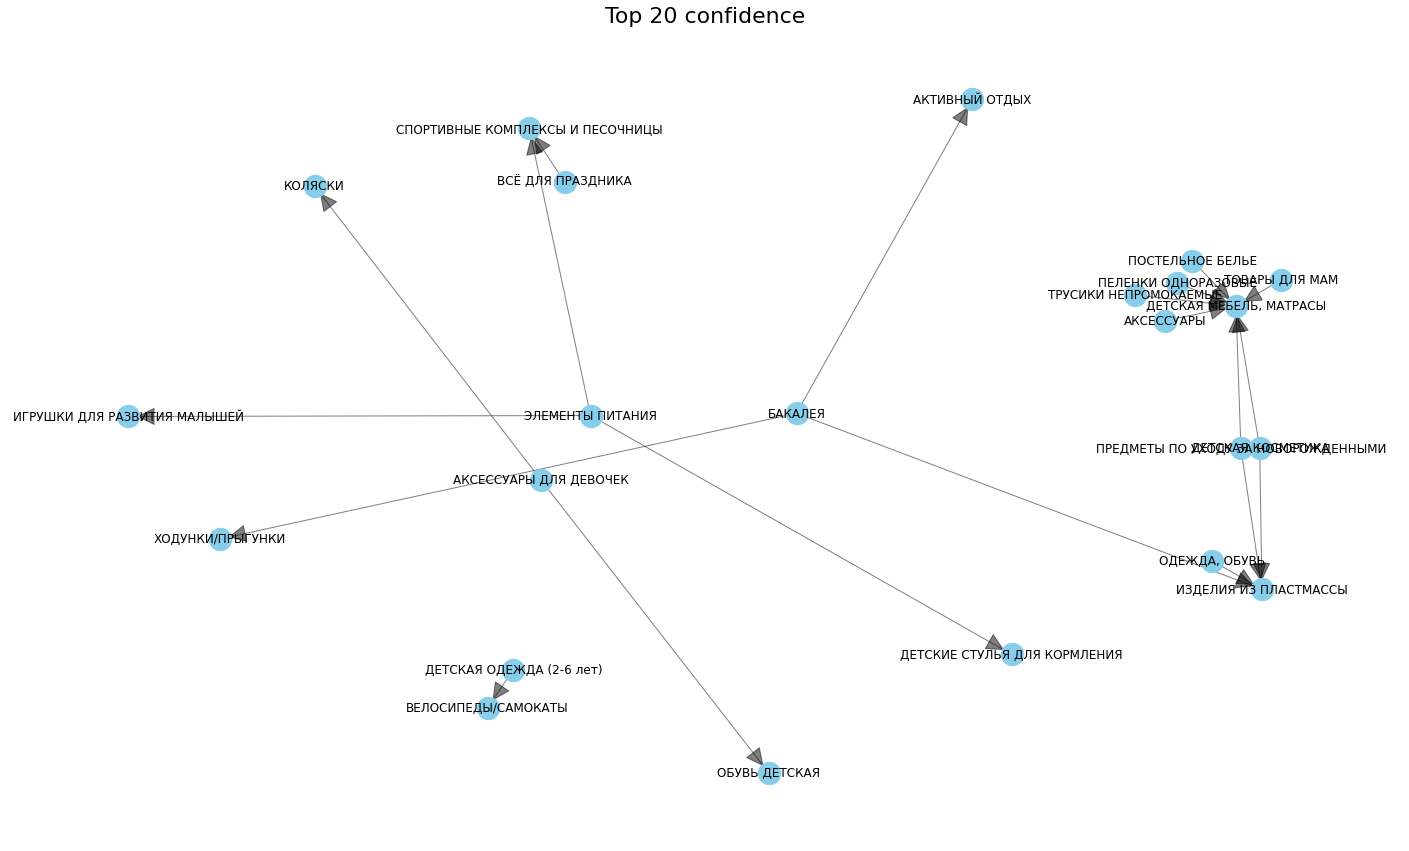

In [197]:
fig = plt.figure(figsize=(25,15))
pos=nx.spring_layout(G_confidence)
nx.draw_networkx_nodes(G_confidence, pos, node_color='skyblue',node_size=500)
nx.draw_networkx_edges(G_confidence, pos, alpha=0.5, arrowsize=40)
nx.draw_networkx_labels(G_confidence,pos)
plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
plt.axis("off")
plt.show()

In [277]:
num_top = 20
feature = 'support'
df_graph_top30_support = df_for_graph(df_ass0, feature, num_top)
G_support=nx.from_pandas_edgelist(df_graph_top30_support, 'antecedents', 'consequents', create_using=nx.DiGraph())

In [278]:
df_ = df_graph_top30_support[df_graph_top30_support['support'] == df_graph_top30_support['support'].max()]
df_

,antecedents,consequents,antecedents_support,consequents_support,support,confidence,lift
0,"ДЕТСКАЯ МЕБЕЛЬ, МАТРАСЫ",КОЛЯСКИ,0.179901,0.275009,0.008306,0.046169,0.167883


In [279]:
df_priority = pd.concat([df_priority, df_])

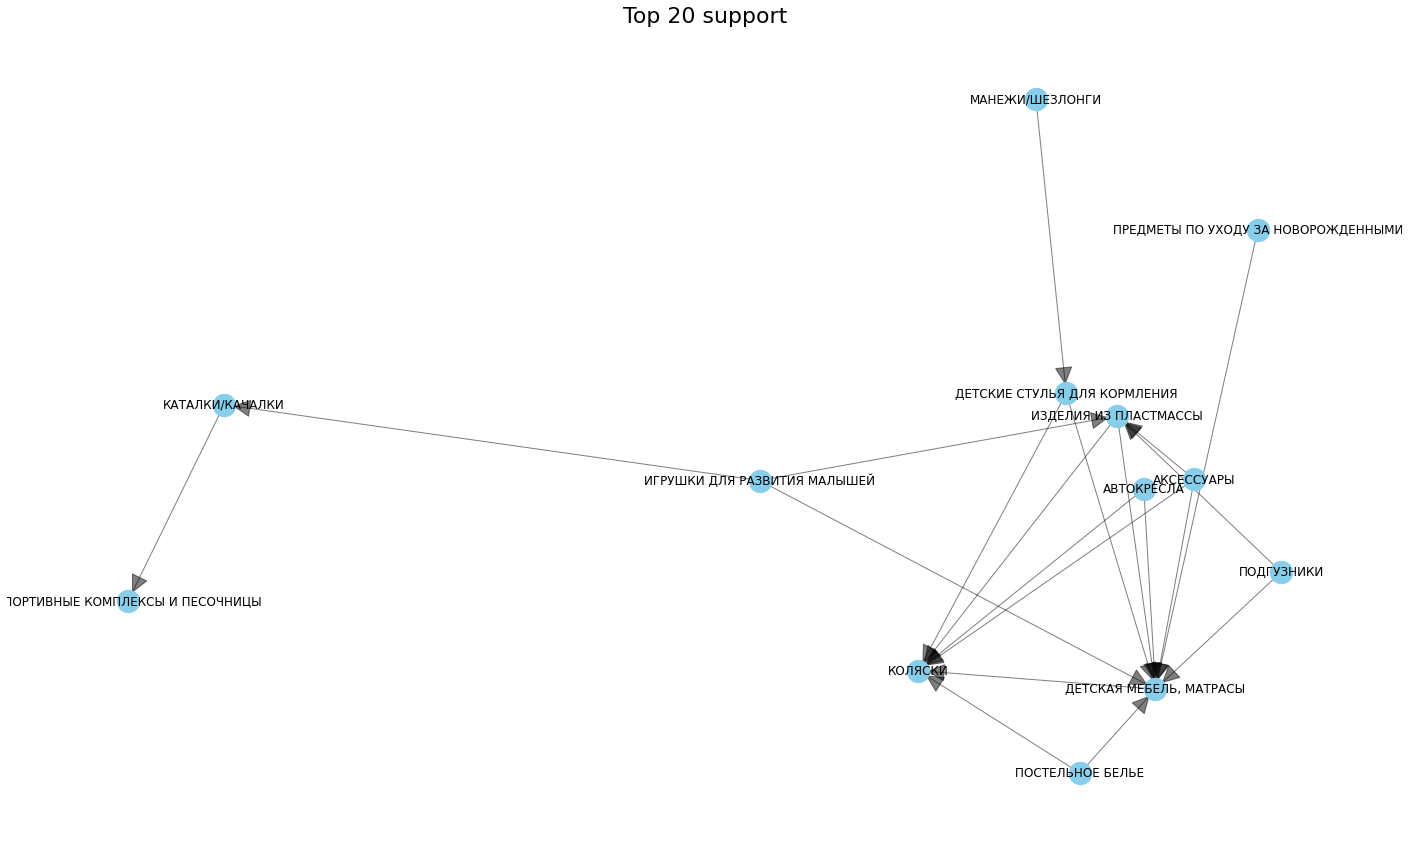

In [202]:
pos=nx.spring_layout(G_support)
fig = plt.figure(figsize=(25,15))
nx.draw_networkx_nodes(G_support,pos, node_color='skyblue',node_size=500)
nx.draw_networkx_edges(G_support, pos, alpha=0.5, arrowsize=40)
nx.draw_networkx_labels(G_support,pos)
plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
plt.axis("off")
plt.show()

In [203]:
num_top = 20
feature = 'lift'
df_graph_top30_lift = df_for_graph(df_ass0, feature, num_top)
G_lift=nx.from_pandas_edgelist(df_graph_top30_lift, 'antecedents', 'consequents', create_using=nx.DiGraph())

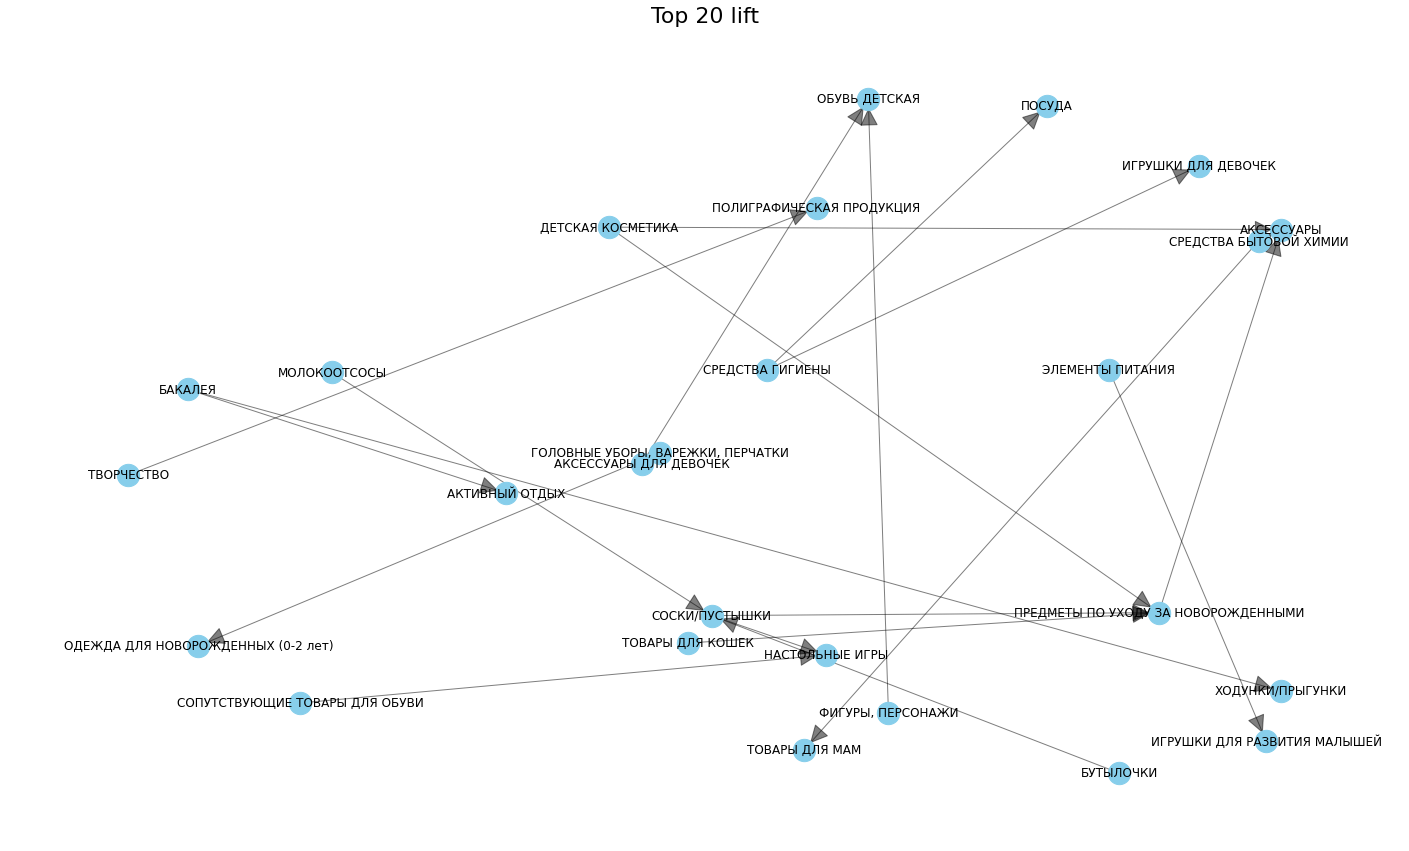

In [206]:
G = G_lift
pos=nx.random_layout(G)
fig = plt.figure(figsize=(25,15))
nx.draw_networkx_nodes(G,pos, node_color='skyblue',node_size=500)
nx.draw_networkx_edges(G, pos, alpha=0.5, arrowsize=40)
nx.draw_networkx_labels(G,pos)
plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
plt.axis("off")
plt.show()

### 4 сегмент

In [280]:
df_buy_segment0 = df_buy[df_buy['Class']==4] 

In [281]:
print('Уникальных клиентов',df_buy_segment0['Телефон_new'].nunique())

Уникальных клиентов 5841


In [282]:
df_buy_segment0_onehot = pd.crosstab(df_buy_segment0.НомерЗаказаНаСайте, 
                                     df_buy_segment0.Группа3,
                                     values=df_buy_segment0['КоличествоПроданоКлиенту'],
                                     aggfunc='sum').fillna(0) # разбивка для ассоциативных правил по сегменту

In [283]:
df_ass0_first = pd.DataFrame(list(itertools.combinations(df_buy_segment0.Группа3.unique(), 2)), columns=['antecedents', 'consequents']) # подсчет парных метрик
df_ass0_second = pd.DataFrame({'antecedents': list(df_ass0_first.consequents), 'consequents': list(df_ass0_first.antecedents)})
df_ass0 = pd.concat([df_ass0_first, df_ass0_second], ignore_index=True)

df_ass0['antecedents_support'] = df_ass0.apply(lambda x: len(df_buy_segment0_onehot[df_buy_segment0_onehot[x['antecedents']]>=1]) /len(df_buy_segment0_onehot), axis = 1)
df_ass0['consequents_support'] = df_ass0.apply(lambda x: len(df_buy_segment0_onehot[df_buy_segment0_onehot[x['consequents']]>=1]) /len(df_buy_segment0_onehot), axis = 1)
df_ass0['support'] = df_ass0.apply(lambda x: len(df_buy_segment0_onehot[(df_buy_segment0_onehot[x['antecedents']]>=1) & (df_buy_segment0_onehot[x['consequents']]>=1)]) /len(df_buy_segment0_onehot), axis = 1)
df_ass0['confidence'] = df_ass0.apply(lambda x: x['support']/x['antecedents_support'], axis = 1)
df_ass0['lift'] = df_ass0.apply(lambda x: x['support']/(x['antecedents_support']*x['consequents_support']), axis = 1)

In [284]:
df_ass0

,antecedents,consequents,antecedents_support,consequents_support,support,confidence,lift
0,ДЕТСКАЯ ОДЕЖДА (2-6 лет),ДЕТСКОЕ БЕЛЬЁ,0.151229,0.060839,0.021232,0.140394,2.307620
1,ДЕТСКАЯ ОДЕЖДА (2-6 лет),ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет),0.151229,0.204495,0.030916,0.204433,0.999701
2,ДЕТСКАЯ ОДЕЖДА (2-6 лет),ДЕТСКИЕ КОЛГОТКИ И НОСКИ,0.151229,0.052645,0.015272,0.100985,1.918243
3,ДЕТСКАЯ ОДЕЖДА (2-6 лет),ОБУВЬ ДЕТСКАЯ,0.151229,0.232679,0.015769,0.104269,0.448124
4,ДЕТСКАЯ ОДЕЖДА (2-6 лет),"ДЕТСКАЯ МЕБЕЛЬ, МАТРАСЫ",0.151229,0.013906,0.000497,0.003284,0.236160
...,...,...,...,...,...,...,...
5397,ТОВАРЫ ДЛЯ ПТИЦ,"АКСЕССУАРЫ МАКИЯЖ, МАНИКЮР",0.000124,0.000124,0.000000,0.000000,0.000000
5398,ТОВАРЫ ДЛЯ ХОРЬКОВ,"АКСЕССУАРЫ МАКИЯЖ, МАНИКЮР",0.000124,0.000124,0.000000,0.000000,0.000000
5399,ТОВАРЫ ДЛЯ ПТИЦ,МОЛОКООТСОСЫ,0.000124,0.000124,0.000000,0.000000,0.000000
5400,ТОВАРЫ ДЛЯ ХОРЬКОВ,МОЛОКООТСОСЫ,0.000124,0.000124,0.000000,0.000000,0.000000


In [214]:
num_top = 20
feature = 'confidence'
df_graph_top30_confidence = df_for_graph(df_ass0, feature, num_top)
G_confidence=nx.from_pandas_edgelist(df_graph_top30_confidence, 'antecedents', 'consequents', create_using=nx.DiGraph())

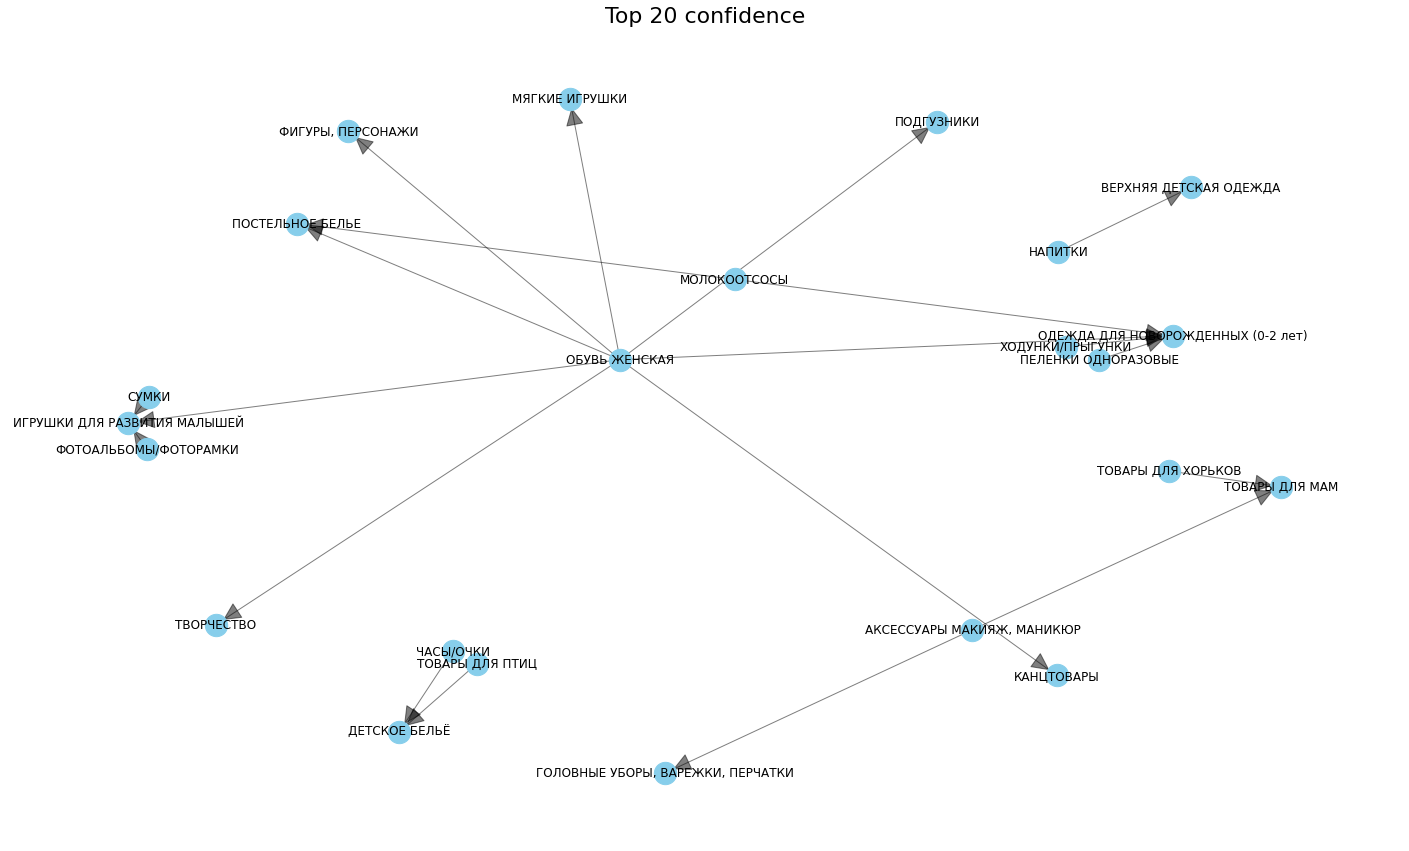

In [216]:
fig = plt.figure(figsize=(25,15))
pos=nx.spring_layout(G_confidence)
nx.draw_networkx_nodes(G_confidence, pos, node_color='skyblue',node_size=500)
nx.draw_networkx_edges(G_confidence, pos, alpha=0.5, arrowsize=40)
nx.draw_networkx_labels(G_confidence,pos)
plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
plt.axis("off")
plt.show()

In [285]:
num_top = 20
feature = 'support'
df_graph_top30_support = df_for_graph(df_ass0, feature, num_top)
G_support=nx.from_pandas_edgelist(df_graph_top30_support, 'antecedents', 'consequents', create_using=nx.DiGraph())

In [286]:
df_ = df_graph_top30_support[df_graph_top30_support['support'] == df_graph_top30_support['support'].max()]
df_

,antecedents,consequents,antecedents_support,consequents_support,support,confidence,lift
0,ДЕТСКАЯ ОДЕЖДА (2-6 лет),ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет),0.151229,0.204495,0.030916,0.204433,0.999701


In [287]:
df_priority = pd.concat([df_priority, df_])

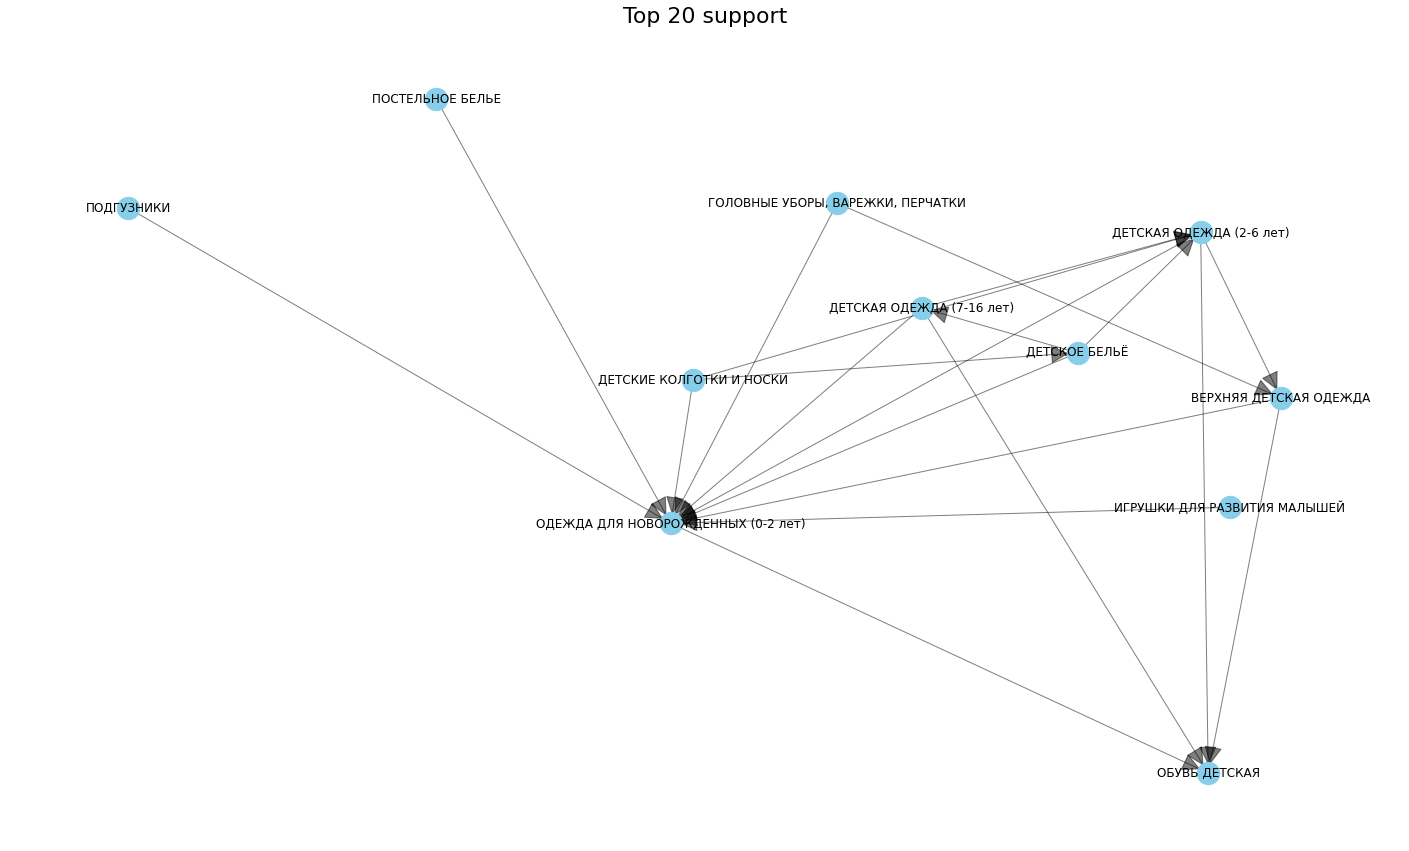

In [218]:
pos=nx.spring_layout(G_support)
fig = plt.figure(figsize=(25,15))
nx.draw_networkx_nodes(G_support,pos, node_color='skyblue',node_size=500)
nx.draw_networkx_edges(G_support, pos, alpha=0.5, arrowsize=40)
nx.draw_networkx_labels(G_support,pos)
plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
plt.axis("off")
plt.show()

In [219]:
num_top = 20
feature = 'lift'
df_graph_top30_lift = df_for_graph(df_ass0, feature, num_top)
G_lift=nx.from_pandas_edgelist(df_graph_top30_lift, 'antecedents', 'consequents', create_using=nx.DiGraph())

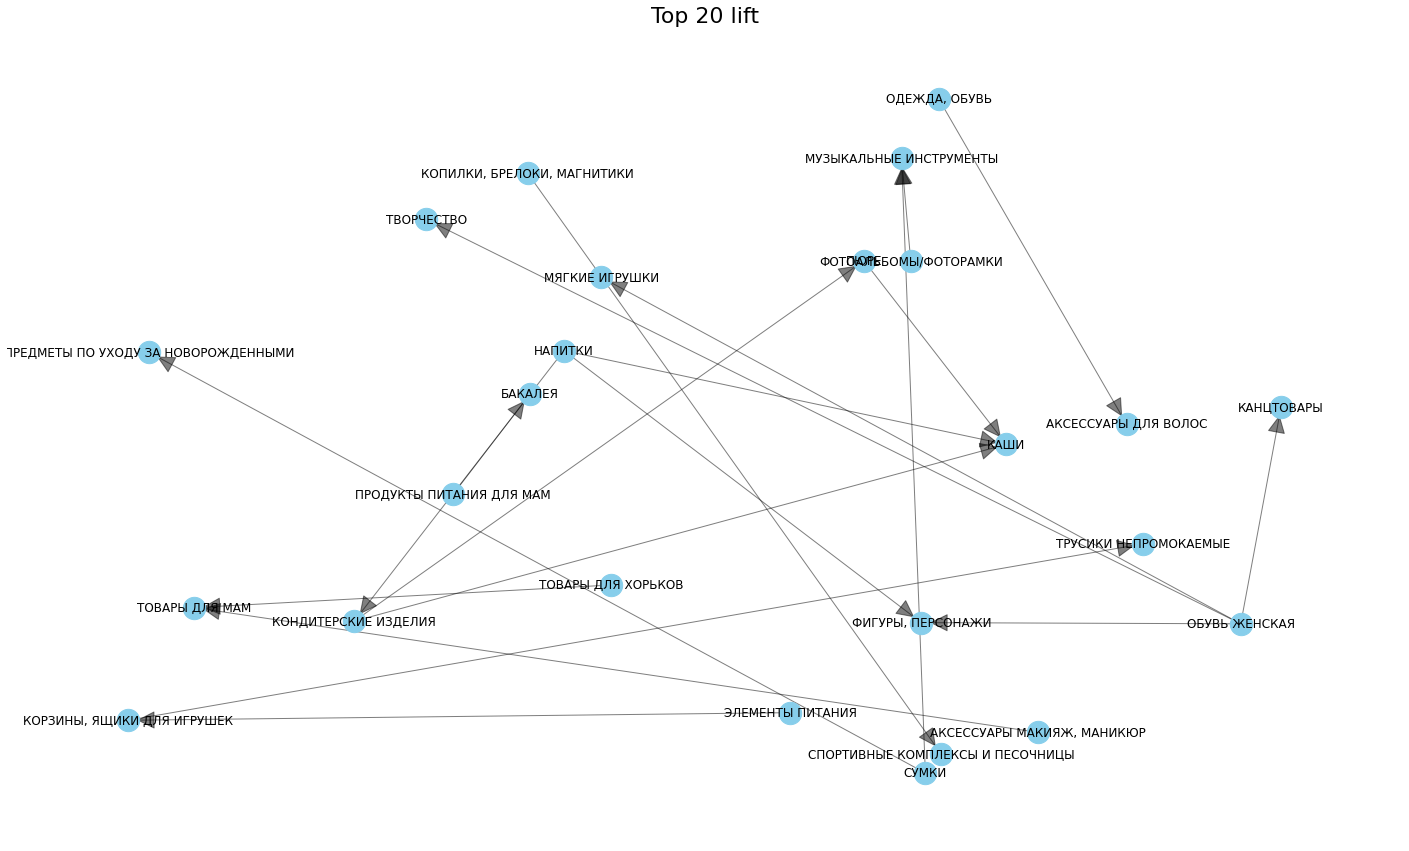

In [220]:
G = G_lift
pos=nx.random_layout(G)
fig = plt.figure(figsize=(25,15))
nx.draw_networkx_nodes(G,pos, node_color='skyblue',node_size=500)
nx.draw_networkx_edges(G, pos, alpha=0.5, arrowsize=40)
nx.draw_networkx_labels(G,pos)
plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
plt.axis("off")
plt.show()

### 5 сегмент

In [288]:
df_buy_segment0 = df_buy[df_buy['Class']==5] 

In [289]:
print('Уникальных клиентов',df_buy_segment0['Телефон_new'].nunique())

Уникальных клиентов 8964


In [290]:
df_buy_segment0_onehot = pd.crosstab(df_buy_segment0.НомерЗаказаНаСайте, 
                                     df_buy_segment0.Группа3,
                                     values=df_buy_segment0['КоличествоПроданоКлиенту'],
                                     aggfunc='sum').fillna(0) # разбивка для ассоциативных правил по сегменту

In [291]:
df_ass0_first = pd.DataFrame(list(itertools.combinations(df_buy_segment0.Группа3.unique(), 2)), columns=['antecedents', 'consequents']) # подсчет парных метрик
df_ass0_second = pd.DataFrame({'antecedents': list(df_ass0_first.consequents), 'consequents': list(df_ass0_first.antecedents)})
df_ass0 = pd.concat([df_ass0_first, df_ass0_second], ignore_index=True)

df_ass0['antecedents_support'] = df_ass0.apply(lambda x: len(df_buy_segment0_onehot[df_buy_segment0_onehot[x['antecedents']]>=1]) /len(df_buy_segment0_onehot), axis = 1)
df_ass0['consequents_support'] = df_ass0.apply(lambda x: len(df_buy_segment0_onehot[df_buy_segment0_onehot[x['consequents']]>=1]) /len(df_buy_segment0_onehot), axis = 1)
df_ass0['support'] = df_ass0.apply(lambda x: len(df_buy_segment0_onehot[(df_buy_segment0_onehot[x['antecedents']]>=1) & (df_buy_segment0_onehot[x['consequents']]>=1)]) /len(df_buy_segment0_onehot), axis = 1)
df_ass0['confidence'] = df_ass0.apply(lambda x: x['support']/x['antecedents_support'], axis = 1)
df_ass0['lift'] = df_ass0.apply(lambda x: x['support']/(x['antecedents_support']*x['consequents_support']), axis = 1)

In [292]:
df_ass0

,antecedents,consequents,antecedents_support,consequents_support,support,confidence,lift
0,ИГРУШКИ ДЛЯ ДЕВОЧЕК,ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ,0.175972,0.294808,0.030758,0.174788,0.592887
1,ИГРУШКИ ДЛЯ ДЕВОЧЕК,КОНСТРУКТОРЫ,0.175972,0.165533,0.011185,0.063559,0.383968
2,ИГРУШКИ ДЛЯ ДЕВОЧЕК,КАНЦТОВАРЫ,0.175972,0.068320,0.009227,0.052436,0.767518
3,ИГРУШКИ ДЛЯ ДЕВОЧЕК,СПОРТИВНЫЕ КОМПЛЕКСЫ И ПЕСОЧНИЦЫ,0.175972,0.007456,0.000652,0.003708,0.497239
4,ИГРУШКИ ДЛЯ ДЕВОЧЕК,ДЕТСКАЯ ОДЕЖДА (2-6 лет),0.175972,0.018548,0.003449,0.019597,1.056589
...,...,...,...,...,...,...,...
6001,"АКСЕССУАРЫ МАКИЯЖ, МАНИКЮР",ЗАМЕНИТЕЛИ МОЛОКА,0.000093,0.000186,0.000000,0.000000,0.000000
6002,"ШАПКИ, ШАРФЫ",ЗАМЕНИТЕЛИ МОЛОКА,0.000093,0.000186,0.000000,0.000000,0.000000
6003,"АКСЕССУАРЫ МАКИЯЖ, МАНИКЮР",НАПИТКИ,0.000093,0.000093,0.000000,0.000000,0.000000
6004,"ШАПКИ, ШАРФЫ",НАПИТКИ,0.000093,0.000093,0.000000,0.000000,0.000000


In [228]:
num_top = 20
feature = 'confidence'
df_graph_top30_confidence = df_for_graph(df_ass0, feature, num_top)
G_confidence=nx.from_pandas_edgelist(df_graph_top30_confidence, 'antecedents', 'consequents', create_using=nx.DiGraph())

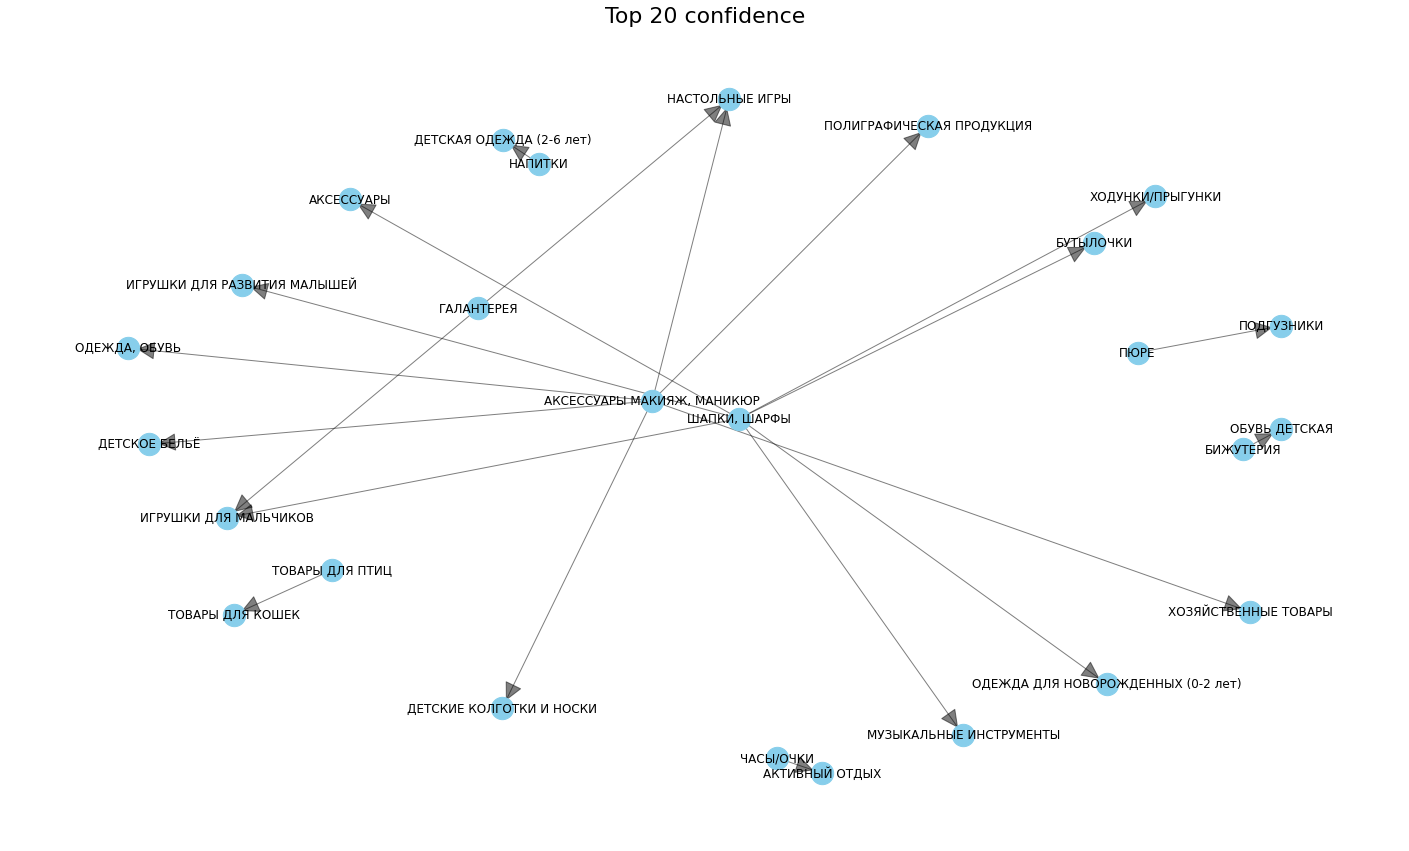

In [229]:
fig = plt.figure(figsize=(25,15))
pos=nx.spring_layout(G_confidence)
nx.draw_networkx_nodes(G_confidence, pos, node_color='skyblue',node_size=500)
nx.draw_networkx_edges(G_confidence, pos, alpha=0.5, arrowsize=40)
nx.draw_networkx_labels(G_confidence,pos)
plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
plt.axis("off")
plt.show()

In [293]:
num_top = 20
feature = 'support'
df_graph_top30_support = df_for_graph(df_ass0, feature, num_top)
G_support=nx.from_pandas_edgelist(df_graph_top30_support, 'antecedents', 'consequents', create_using=nx.DiGraph())

In [294]:
df_ = df_graph_top30_support[df_graph_top30_support['support'] == df_graph_top30_support['support'].max()]
df_

,antecedents,consequents,antecedents_support,consequents_support,support,confidence,lift
0,НАСТОЛЬНЫЕ ИГРЫ,ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ,0.119396,0.294808,0.032901,0.275566,0.934729


In [295]:
df_priority = pd.concat([df_priority, df_])

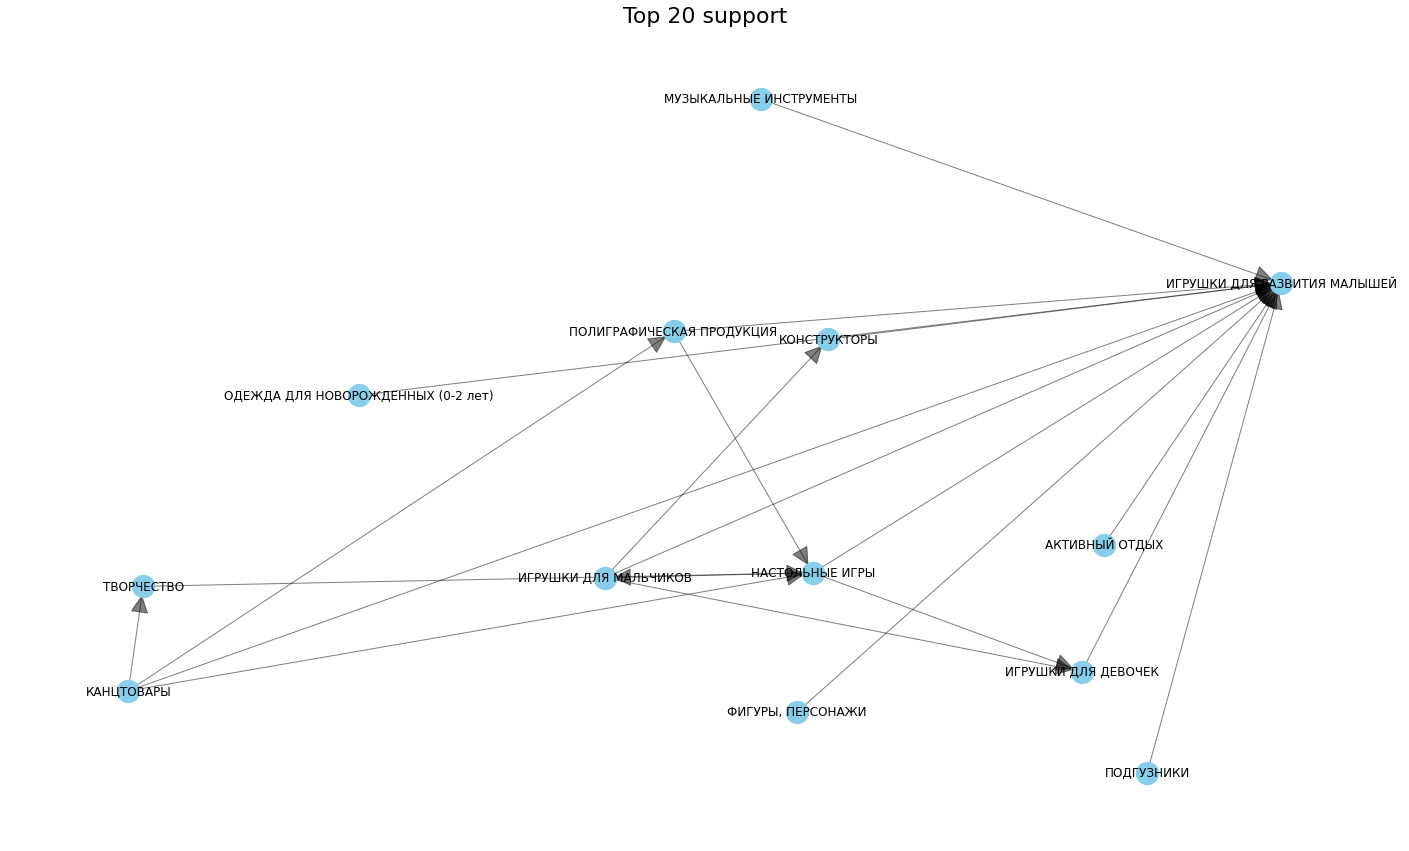

In [232]:
pos=nx.spring_layout(G_support)
fig = plt.figure(figsize=(25,15))
nx.draw_networkx_nodes(G_support,pos, node_color='skyblue',node_size=500)
nx.draw_networkx_edges(G_support, pos, alpha=0.5, arrowsize=40)
nx.draw_networkx_labels(G_support,pos)
plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
plt.axis("off")
plt.show()

In [233]:
num_top = 20
feature = 'lift'
df_graph_top30_lift = df_for_graph(df_ass0, feature, num_top)
G_lift=nx.from_pandas_edgelist(df_graph_top30_lift, 'antecedents', 'consequents', create_using=nx.DiGraph())

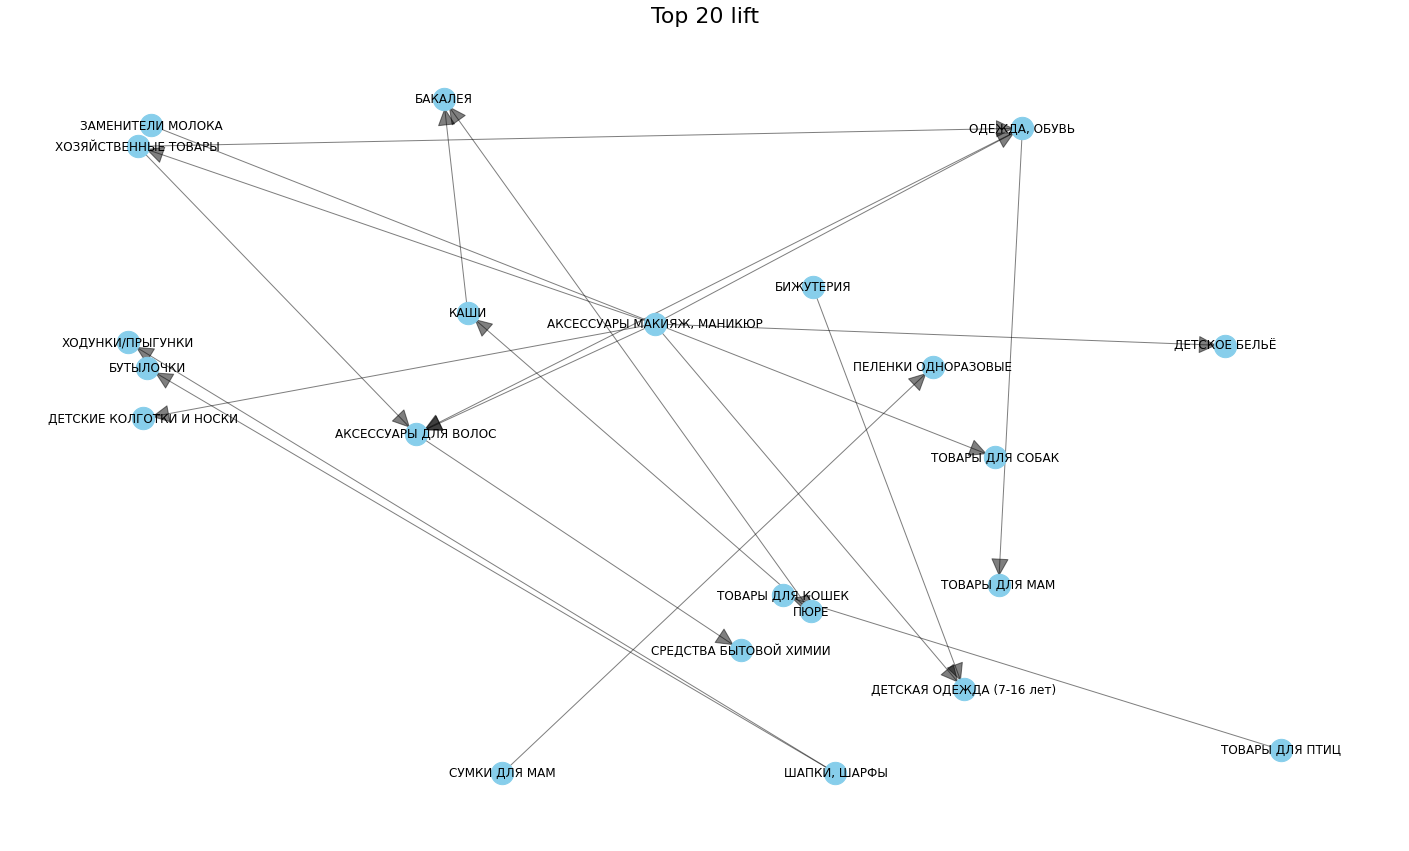

In [238]:
G = G_lift
pos=nx.random_layout(G)
fig = plt.figure(figsize=(25,15))
nx.draw_networkx_nodes(G,pos, node_color='skyblue',node_size=500)
nx.draw_networkx_edges(G, pos, alpha=0.5, arrowsize=40)
nx.draw_networkx_labels(G,pos)
plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
plt.axis("off")
plt.show()

# Total

In [298]:
df_priority.index = df3.index
df_priority

,antecedents,consequents,antecedents_support,consequents_support,support,confidence,lift
Class,,,,,,,
0,СРЕДСТВА ГИГИЕНЫ,ПОДГУЗНИКИ,0.058239,0.441938,0.037951,0.651646,1.474520
1,СРЕДСТВА ГИГИЕНЫ,ПОДГУЗНИКИ,0.112779,0.482120,0.070162,0.622125,1.290395
2,НАСТОЛЬНЫЕ ИГРЫ,ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ,0.124336,0.256004,0.030499,0.245299,0.958184
3,"ДЕТСКАЯ МЕБЕЛЬ, МАТРАСЫ",КОЛЯСКИ,0.179901,0.275009,0.008306,0.046169,0.167883
4,ДЕТСКАЯ ОДЕЖДА (2-6 лет),ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет),0.151229,0.204495,0.030916,0.204433,0.999701
5,НАСТОЛЬНЫЕ ИГРЫ,ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ,0.119396,0.294808,0.032901,0.275566,0.934729


In [241]:
df3

,Приоритетный товарный Тип,Приоритетная товарная категория в Группа2,Приоритетная товарная категория в Группа3,Выручка,Абсолютная Маржа,Маржа (процентное соотношение),Количество чеков,Количество товаров,Количество клиентов,Средний чек,Среднее количество товаров в чеке,Ценность клиента
Class,,,,,,,,,,,,
0,ППКП,ПОДГУЗНИКИ,ПОДГУЗНИКИ,49749548.85,8263411.98,0.166100,19815.0,67279.0,14351.0,2510.701431,3.395357,575.807399
1,ППКП,ДЕТСКОЕ ПИТАНИЕ,ПЮРЕ,40611826.00,4952097.96,0.121937,16191.0,125335.0,10433.0,2508.296337,7.741029,474.657142
2,ИГРУШКИ,ИГРУШКИ,ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ,17235388.18,3620173.28,0.210043,9410.0,29675.0,7963.0,1831.603420,3.153560,454.624297
3,КГТ,КРУПНОГАБАРИТНЫЙ ТОВАР,КОЛЯСКИ,83028755.70,25137077.37,0.302751,10956.0,12878.0,10197.0,7578.382229,1.175429,2465.144392
4,ОДЕЖДА,"ТЕКСТИЛЬ, ТРИКОТАЖ",ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет),19406585.43,5743062.24,0.295934,8054.0,23650.0,5841.0,2409.558658,2.936429,983.232707
5,ИГРУШКИ,ИГРУШКИ,ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ,21658207.40,4768149.45,0.220154,10729.0,32469.0,8964.0,2018.660397,3.026284,531.922072


In [297]:
df3.index

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64', name='Class')

# СТАРОЕ

добавим веса вершинам и ребрам

In [ ]:
def summary_buy(x):
    result = {
        'Выручка': x['СуммаСтроки'].sum(),
        'Абсолютная Маржа': x['Маржа'].sum(),
        'Маржа (процентное соотношение)': x['Маржа'].sum() / x['СуммаСтроки'].sum(),
        'Количество чеков': x['НомерЗаказаНаСайте'].nunique(),
        'Количество товаров': x['КоличествоПроданоКлиенту'].sum(),
        'Количество клиентов': x['Телефон_new'].nunique(),        
        'Средний чек': x['СуммаСтроки'].sum() / x['НомерЗаказаНаСайте'].nunique(),
        'Среднее количество товаров в чеке': x['КоличествоПроданоКлиенту'].sum() / x['НомерЗаказаНаСайте'].nunique(),
        'Ценность клиента': x['Маржа'].sum() / x['Телефон_new'].nunique()
    }
    return pd.Series(result).round(3)

In [ ]:
def df_for_graph(df, column_for_sort, num_top, dict_margin): # добавили маржу
    df_top = df.copy()
    df_top.sort_values(by='confidence', axis=0, ascending=False, inplace=True)
    df_top['new'] = df_top.apply(lambda x: '_'.join(np.sort([x['antecedents'], x['consequents']])), axis=1)
    df_top.reset_index(drop=True, inplace=True)
    df_top.drop_duplicates(subset=['new'], keep='first', inplace=True)
    df_top.drop(['new'], axis=1, inplace=True)
    df_top = df_top[df_top['support']>0]
    df_top.sort_values(by=column_for_sort, axis=0, ascending=False, inplace=True)
    df_top.reset_index(drop=True, inplace=True)

    df_top['Margin Product A'] = df_top.apply(lambda x: dict_margin[x['antecedents']], axis = 1)
    df_top['Margin Product B'] = df_top.apply(lambda x: dict_margin[x['consequents']], axis = 1)
    df_top['Margin sum'] = df_top.apply(lambda x: x['Margin Product A'] + x['Margin Product B'], axis = 1)
    return df_top.head(num_top)

In [ ]:
dict_margin = df_buy.groupby(['Группа3']).apply(summary_buy)[['Абсолютная Маржа']].to_dict()['Абсолютная Маржа']

In [ ]:
df_graph_top30_support = df_for_graph(df_ass0, 'support', num_top, dict_margin)

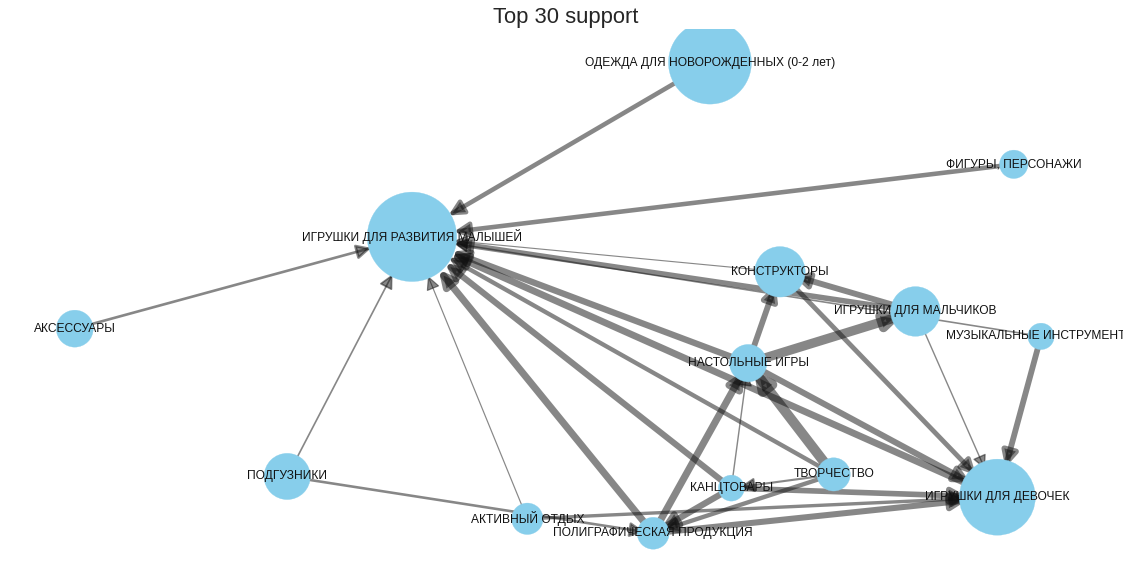

In [ ]:
# pos=nx.spring_layout(G_support)
# fig = plt.figure(figsize=(20,10))
# node_size_list = [dict_margin[i]/np.max(df_graph_top30_support[['Margin Product A','Margin Product B']].max()) * 8000 for i in G_support.nodes()]
# nx.draw_networkx_nodes(G_support,pos, node_color='skyblue', node_size= node_size_list)
# for edge, w in zip(G_support.edges(), list(df_graph_top30_support['Margin sum']/df_graph_top30_support['Margin sum'].max() * 10)):
#     nx.draw_networkx_edges(
#         G_support, 
#         pos,
#         edgelist = [edge],
#         alpha=0.5, 
#         arrowsize=30, 
#         width=w,
#         min_target_margin=node_size_list[list(G_support.nodes()).index(edge[1])] / 190
#     )
# nx.draw_networkx_labels(G_support,pos)
# plt.title(('Top '+str(num_top)+' '+str(feature)), fontsize=22)
# plt.axis("off")
# plt.show()

In [ ]:
df = df_for_graph(df_ass0, 'support', num_top, dict_margin)


G=nx.from_pandas_edgelist(df, 'antecedents', 'consequents', create_using=nx.DiGraph())
node_size_list = [dict_margin[i]/np.max(df[['Margin Product A','Margin Product B']].max()) * 90 for i in np.unique(np.array(G.edges()).flatten())]
edge_size_list = list(df['Margin sum']/df['Margin sum'].max() * 10)

vstyle = {"stroke":toyplot.color.black,  "stroke-width":2.0}
layout = toyplot.layout.FruchtermanReingold()

canvas, axes, mark = toyplot.graph(
    np.array(G.edges()),
    layout=layout,
    ecolor="black",
    tmarker=toyplot.marker.create(shape=">", mstyle={"fill":"silver"}),
    ewidth=edge_size_list,
    vcolor='skyblue',
    vsize=node_size_list,
    vstyle=vstyle,
    vlstyle={"font-size":"18px"},
    height=700,
    width=1000,
    padding=300,
    eopacity=0.2
)
# toyplot.png.render(canvas)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1000.0px" height="700.0px" viewBox="0 0 1000.0 700.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t897c1fb1d00f4706acdf7e7b67fce41a"> АКСЕССУАРЫ АКТИВНЫЙ ОТДЫХ ИГРУШКИ ДЛЯ ДЕВОЧЕК ИГРУШКИ ДЛЯ МАЛЬЧИКОВ ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ КАНЦТОВАРЫ КОНСТРУКТОРЫ МУЗЫКАЛЬНЫЕ ИНСТРУМЕНТЫ НАСТОЛЬНЫЕ ИГРЫ ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет) ПОДГУЗНИКИ ПОЛИГРАФИЧЕСКАЯ ПРОДУКЦИЯ ТВОРЧЕСТВО ФИГУРЫ, ПЕРСОНАЖИ

In [ ]:
df = df_for_graph(df_ass0, 'lift', num_top, dict_margin)

G=nx.from_pandas_edgelist(df, 'antecedents', 'consequents', create_using=nx.DiGraph())
node_size_list = [dict_margin[i]/np.max(df[['Margin Product A','Margin Product B']].max()) * 100 for i in np.unique(np.array(G.edges()).flatten())]
edge_size_list = list(df['Margin sum']/df['Margin sum'].max() * 10)

vstyle = {"stroke":toyplot.color.black,  "stroke-width":2.0}
layout = toyplot.layout.FruchtermanReingold(temperature=0.04)



canvas, axes, mark = toyplot.graph(
    np.array(G.edges()),
    layout=layout,
    ecolor="black",
    tmarker=toyplot.marker.create(shape=">", mstyle={"fill":"silver"}),
    ewidth=edge_size_list,
    vcolor='skyblue',
    vsize=node_size_list,
    vstyle=vstyle,
    vlstyle={"font-size":"10px"},
    height=700,
    width=1000,
    padding=300,
    eopacity=0.2
)
# toyplot.png.render(canvas)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1000.0px" height="700.0px" viewBox="0 0 1000.0 700.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t99f3584455ad4609a0b4d36977286c20"> АКСЕССУАРЫ ДЛЯ ВОЛОС АКСЕССУАРЫ ДЛЯ ДЕВОЧЕК АКСЕССУАРЫ МАКИЯЖ, МАНИКЮР БАКАЛЕЯ БИЖУТЕРИЯ БУТЫЛОЧКИ ДЕТСКАЯ КОСМЕТИКА ДЕТСКАЯ ОДЕЖДА (7-16 лет) ДЕТСКИЕ КОЛГОТКИ И НОСКИ КАШИ КОНДИТЕРСКИЕ ИЗДЕЛИЯ КОПИЛКИ, БРЕЛОКИ, МАГНИТИКИ ЛАМПЫ/СВЕТИЛЬНИКИ НАПИТКИ ОБУВЬ ДЕТСКАЯ ОДЕЖДА, ОБУВЬ ПЕЛЕНКИ ОДНОРАЗОВЫЕ ПОСТЕЛЬНОЕ БЕЛЬЕ ПРОДУКТЫ ПИТАНИЯ ДЛЯ МАМ САНКИ/СНЕГОКАТЫ СОСКИ/ПУСТЫШКИ СРЕДСТВА БЫТОВОЙ ХИМИИ СУМКИ СУМКИ ДЛЯ МАМ ТОВАРЫ ДЛЯ ГРЫЗУНОВ ТОВАРЫ ДЛЯ КОШЕК ТОВАРЫ ДЛЯ ПТИЦ ТОВАРЫ ДЛЯ РЫБ ХОДУНКИ/ПРЫГУНКИ ХОЗЯЙСТВЕННЫЕ ТОВАРЫ ШАПКИ, ШАРФЫ ЭЛЕКТРОПРИБОРЫ